In [1]:
import pandas as pd

In [19]:
DATA_DIR = 'equity-post-HCT-survival-predictions-1'


#train_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
#test_data  = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

train_data = pd.read_csv(DATA_DIR +'/train.csv')
test_data  = pd.read_csv(DATA_DIR +'/test.csv')

df = train_data

In [23]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

def fit_univariate_cox(df, feature, time_col, event_col):
    """
    Fits a univariate Cox proportional hazards model for a single feature.
    Handles NaN values by dropping them before analysis.
    """
    # Create a DataFrame with just the necessary columns
    analysis_df = df[[feature, time_col, event_col]].copy()

    try:
        # Count NaNs before dropping
        n_total = len(analysis_df)
        n_missing = analysis_df[feature].isnull().sum()

        # Drop NaN values
        analysis_df = analysis_df.dropna(subset=[feature, time_col, event_col])

        # If we have too few samples after dropping NaNs, return error
        if len(analysis_df) < 10:  # arbitrary threshold, adjust as needed
            return {
                'hazard_ratio': None,
                'p_value': None,
                'ci_lower': None,
                'ci_upper': None,
                'error': f"Too few samples ({len(analysis_df)}) after dropping {n_missing} NaN values"
            }

        # Fit Cox model
        cph = CoxPHFitter()
        cph.fit(analysis_df, duration_col=time_col, event_col=event_col)

        # Extract results
        hazard_ratio = np.exp(cph.params_[0])
        p_value = cph.summary.p[0]

        # Try different possible column names for confidence intervals
        try:
            ci_lower = np.exp(cph.confidence_intervals_['coef lower 95%'][0])
            ci_upper = np.exp(cph.confidence_intervals_['coef upper 95%'][0])
        except KeyError:
            try:
                ci_lower = np.exp(cph.confidence_intervals_['95% lower'][0])
                ci_upper = np.exp(cph.confidence_intervals_['95% upper'][0])
            except KeyError:
                ci_lower = None
                ci_upper = None

        return {
            'hazard_ratio': hazard_ratio,
            'p_value': p_value,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'n_total': n_total,
            'n_analyzed': len(analysis_df),
            'n_missing': n_missing
        }
    except Exception as e:
        return {
            'hazard_ratio': None,
            'p_value': None,
            'ci_lower': None,
            'ci_upper': None,
            'error': str(e),
            'n_total': n_total if 'n_total' in locals() else None,
            'n_missing': n_missing if 'n_missing' in locals() else None
        }

def perform_logrank(df, feature, time_col, event_col):
    """
    Performs log-rank test for categorical variables.
    Handles NaN values by dropping them before analysis.
    """
    try:
        # Create a DataFrame with just the necessary columns
        analysis_df = df[[feature, time_col, event_col]].copy()

        # Count NaNs before dropping
        n_total = len(analysis_df)
        n_missing = analysis_df[feature].isnull().sum()

        # Drop NaN values
        analysis_df = analysis_df.dropna(subset=[feature, time_col, event_col])

        if len(analysis_df) < 10:  # arbitrary threshold
            return {
                'test_statistic': None,
                'p_value': None,
                'error': f"Too few samples ({len(analysis_df)}) after dropping {n_missing} NaN values",
                'n_total': n_total,
                'n_missing': n_missing
            }

        categories = analysis_df[feature].unique()
        if len(categories) == 2:
            # Binary categorical variable
            group1_mask = analysis_df[feature] == categories[0]
            group2_mask = analysis_df[feature] == categories[1]

            result = logrank_test(
                analysis_df[group1_mask][time_col],
                analysis_df[group2_mask][time_col],
                analysis_df[group1_mask][event_col],
                analysis_df[group2_mask][event_col]
            )

            return {
                'test_statistic': result.test_statistic,
                'p_value': result.p_value,
                'n_total': n_total,
                'n_analyzed': len(analysis_df),
                'n_missing': n_missing
            }
        else:
            # Multi-category variable
            results = {}
            for i, cat1 in enumerate(categories):
                for cat2 in categories[i+1:]:
                    group1_mask = analysis_df[feature] == cat1
                    group2_mask = analysis_df[feature] == cat2

                    result = logrank_test(
                        analysis_df[group1_mask][time_col],
                        analysis_df[group2_mask][time_col],
                        analysis_df[group1_mask][event_col],
                        analysis_df[group2_mask][event_col]
                    )

                    results[f'{cat1}_vs_{cat2}'] = {
                        'test_statistic': result.test_statistic,
                        'p_value': result.p_value
                    }

            results['summary'] = {
                'n_total': n_total,
                'n_analyzed': len(analysis_df),
                'n_missing': n_missing
            }
            return results

    except Exception as e:
        return {
            'test_statistic': None,
            'p_value': None,
            'error': str(e),
            'n_total': n_total if 'n_total' in locals() else None,
            'n_missing': n_missing if 'n_missing' in locals() else None
        }

def test_interaction(df, feature1, feature2, time_col, event_col):
    """
    Tests for interaction effects between two features using Cox regression.
    Handles NaN values by dropping them before analysis.
    """
    try:
        # Create DataFrame with necessary columns
        analysis_df = df[[feature1, feature2, time_col, event_col]].copy()

        # Count NaNs before dropping
        n_total = len(analysis_df)
        n_missing = analysis_df[[feature1, feature2]].isnull().any(axis=1).sum()

        # Drop NaN values
        analysis_df = analysis_df.dropna(subset=[feature1, feature2, time_col, event_col])

        if len(analysis_df) < 10:  # arbitrary threshold
            return {
                'interaction_hazard_ratio': None,
                'interaction_p_value': None,
                'error': f"Too few samples ({len(analysis_df)}) after dropping {n_missing} NaN values",
                'n_total': n_total,
                'n_missing': n_missing
            }

        # Create interaction term
        analysis_df['interaction'] = analysis_df[feature1] * analysis_df[feature2]

        # Fit Cox model with interaction
        cph = CoxPHFitter()
        cph.fit(analysis_df, duration_col=time_col, event_col=event_col)

        # Extract interaction term results
        interaction_hr = np.exp(cph.params_['interaction'])
        interaction_p = cph.summary.p['interaction']

        return {
            'interaction_hazard_ratio': interaction_hr,
            'interaction_p_value': interaction_p,
            'n_total': n_total,
            'n_analyzed': len(analysis_df),
            'n_missing': n_missing
        }
    except Exception as e:
        return {
            'interaction_hazard_ratio': None,
            'interaction_p_value': None,
            'error': str(e),
            'n_total': n_total if 'n_total' in locals() else None,
            'n_missing': n_missing if 'n_missing' in locals() else None
        }

def automated_analysis(df, time_col, event_col):
    """
    Performs automated survival analysis on a dataset.
    Now handles NaN values appropriately.
    """
    results = {}

    # Univariate analysis
    for feature in df.columns:
        if feature not in [time_col, event_col]:
            if df[feature].dtype in ['float64', 'int64']:
                # Numerical analysis
                cox_result = fit_univariate_cox(df, feature, time_col, event_col)
                results[feature] = {
                    'univariate_cox': cox_result,
                    'correlation_with_time': df[feature].corr(df[time_col])
                }
            else:
                # Categorical analysis
                results[feature] = {
                    'log_rank': perform_logrank(df, feature, time_col, event_col)
                }

    # Multivariate - pairs of features
    numerical_features = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    for i, f1 in enumerate(numerical_features):
        for f2 in numerical_features[i+1:]:
            if f1 != time_col and f2 != time_col and f1 != event_col and f2 != event_col:
                results[f'{f1}_x_{f2}'] = {
                    'interaction_effect': test_interaction(df, f1, f2, time_col, event_col)
                }

    return results

In [24]:
results = automated_analysis(df, 'efs_time', 'efs')

# Example of checking results for a specific feature
for feature, result in results.items():
    if 'univariate_cox' in result:
        cox_result = result['univariate_cox']
        print(f"\nFeature: {feature}")
        print(f"Total samples: {cox_result.get('n_total')}")
        print(f"Analyzed samples: {cox_result.get('n_analyzed')}")
        print(f"Missing values: {cox_result.get('n_missing')}")
        print(f"Hazard ratio: {cox_result.get('hazard_ratio')}")
        print(f"P-value: {cox_result.get('p_value')}")
        if 'error' in cox_result:
            print(f"Error: {cox_result['error']}")

/opt/anaconda3/envs/kaggle1/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/opt/anaconda3/envs/kaggle1/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/opt/anaconda3/envs/kaggle1/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examp


Feature: ID
Total samples: 28800
Analyzed samples: 28800
Missing values: 0
Hazard ratio: 0.9999994494400455
P-value: 0.5681354249054621

Feature: hla_match_c_high
Total samples: 28800
Analyzed samples: 24180
Missing values: 4620
Hazard ratio: 1.0657086664927937
P-value: 0.0021435430801596176

Feature: hla_high_res_8
Total samples: 28800
Analyzed samples: 22971
Missing values: 5829
Hazard ratio: 1.023295071767978
P-value: 8.581694925896331e-05

Feature: hla_low_res_6
Total samples: 28800
Analyzed samples: 25530
Missing values: 3270
Hazard ratio: 1.0359440505068065
P-value: 9.439976807290085e-07

Feature: hla_high_res_6
Total samples: 28800
Analyzed samples: 23516
Missing values: 5284
Hazard ratio: 1.0302940781110044
P-value: 6.284469997739286e-05

Feature: hla_high_res_10
Total samples: 28800
Analyzed samples: 21637
Missing values: 7163
Hazard ratio: 1.022695930882401
P-value: 7.081249135824539e-06

Feature: hla_match_dqb1_high
Total samples: 28800
Analyzed samples: 23601
Missing value

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from lifelines import KaplanMeierFitter
# import numpy as np
# 
# def automated_analysis_with_plots(df, time_col, event_col, output_dir='analysis_plots/'):
#     for feature in df.columns:
#         if df[feature].dtype in ['float64', 'int64']:
#             # Numerical Feature Plots
# 
#             # Distribution Plot
#             plt.figure(figsize=(10, 6))
#             sns.histplot(data=df, x=feature, hue=event_col, multiple="layer")
#             plt.title(f'Distribution of {feature} by Event')
#             plt.savefig(f'{output_dir}/dist_{feature}.png')
#             plt.close()
# 
#             # Boxplot
#             plt.figure(figsize=(8, 6))
#             sns.boxplot(data=df, y=feature, x=event_col)
#             plt.title(f'Boxplot of {feature} by Event')
#             plt.savefig(f'{output_dir}/box_{feature}.png')
#             plt.close()
# 
#             # Scatter with survival time
#             plt.figure(figsize=(8, 6))
#             sns.scatterplot(data=df, x=feature, y=time_col, hue=event_col)
#             plt.title(f'{feature} vs Survival Time')
#             plt.savefig(f'{output_dir}/scatter_{feature}.png')
#             plt.close()
# 
#             # KM curves for binned numerical values
#             plt.figure(figsize=(10, 6))
#             # Create bins
#             df[f'{feature}_binned'] = pd.qcut(df[feature], q=4, duplicates='drop')
#             kmf = KaplanMeierFitter()
#             for bin_val in df[f'{feature}_binned'].unique():
#                 mask = df[f'{feature}_binned'] == bin_val
#                 kmf.fit(df[mask][time_col],
#                         df[mask][event_col],
#                         label=str(bin_val))
#                 kmf.plot()
#             plt.title(f'KM Curves for {feature} (Binned)')
#             plt.savefig(f'{output_dir}/km_{feature}.png')
#             plt.close()
# 
#         else:
#             # Categorical Feature Plots
# 
#             # Bar plot of event rate by category
#             plt.figure(figsize=(10, 6))
#             event_rates = df.groupby(feature)[event_col].mean()
#             event_rates.plot(kind='bar')
#             plt.title(f'Event Rate by {feature}')
#             plt.savefig(f'{output_dir}/bar_{feature}.png')
#             plt.close()
# 
#             # KM curves for each category
#             plt.figure(figsize=(10, 6))
#             kmf = KaplanMeierFitter()
#             for category in df[feature].unique():
#                 mask = df[feature] == category
#                 if mask.sum() > 5:  # Only plot if enough samples
#                     kmf.fit(df[mask][time_col],
#                             df[mask][event_col],
#                             label=str(category))
#                     kmf.plot()
#             plt.title(f'KM Curves for {feature}')
#             plt.savefig(f'{output_dir}/km_cat_{feature}.png')
#             plt.close()
# 
#         # Missing value analysis if applicable
#         if df[feature].isnull().any():
#             plt.figure(figsize=(10, 6))
#             kmf = KaplanMeierFitter()
#             # Compare missing vs non-missing
#             missing_mask = df[feature].isnull()
#             kmf.fit(df[~missing_mask][time_col],
#                     df[~missing_mask][event_col],
#                     label='Present')
#             kmf.plot()
#             kmf.fit(df[missing_mask][time_col],
#                     df[missing_mask][event_col],
#                     label='Missing')
#             kmf.plot()
#             plt.title(f'KM Curves for {feature} Missing vs Present')
#             plt.savefig(f'{output_dir}/missing_{feature}.png')
#             plt.close()
# 
# # Usage:
# automated_analysis_with_plots(df, 'efs_time', 'efs')

In [11]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class MissingnessAnalyzer:
    def __init__(self, df, time_col='efs_time', event_col='efs'):
        """
        Initialize the missingness analyzer
        
        Parameters:
        -----------
        df : pandas DataFrame
            The dataset to analyze
        time_col : str
            Name of the column containing survival times
        event_col : str
            Name of the column containing event indicators (1 for event, 0 for censored)
        """
        self.df = df.copy()
        self.time_col = time_col
        self.event_col = event_col

        # Convert event column to binary if categorical
        if self.df[event_col].dtype == 'object':
            self.df[event_col] = (self.df[event_col] == 'Event').astype(int)

    def get_missingness_summary(self):
        """Returns a summary of missingness for each column"""
        missing_summary = pd.DataFrame({
            'missing_count': self.df.isnull().sum(),
            'missing_percentage': (self.df.isnull().sum() / len(self.df) * 100).round(2)
        }).sort_values('missing_percentage', ascending=False)

        return missing_summary

    def analyze_feature_missingness(self, feature, plot=True):
        """
        Analyze survival differences between groups with missing vs present values
        
        Parameters:
        -----------
        feature : str
            Name of the feature to analyze
        plot : bool
            Whether to generate a plot
        
        Returns:
        --------
        dict with test statistics and p-value
        """
        if feature not in self.df.columns:
            raise ValueError(f"Feature {feature} not found in dataset")

        missing_mask = self.df[feature].isna()

        # Skip if no missing values
        if not missing_mask.any():
            return {
                'feature': feature,
                'missing_count': 0,
                'missing_percentage': 0,
                'logrank_statistic': None,
                'p_value': None
            }

        kmf = KaplanMeierFitter()

        # Fit KM curves
        kmf_present = kmf.fit(
            self.df[~missing_mask][self.time_col],
            self.df[~missing_mask][self.event_col],
            label='Present'
        )

        kmf_missing = kmf.fit(
            self.df[missing_mask][self.time_col],
            self.df[missing_mask][self.event_col],
            label='Missing'
        )

        # Perform logrank test
        results = logrank_test(
            self.df[~missing_mask][self.time_col],
            self.df[missing_mask][self.time_col],
            self.df[~missing_mask][self.event_col],
            self.df[missing_mask][self.event_col]
        )

        if plot:
            self._plot_survival_curves(feature, kmf_present, kmf_missing, results.p_value)

        return {
            'feature': feature,
            'missing_count': missing_mask.sum(),
            'missing_percentage': (missing_mask.sum() / len(self.df) * 100).round(2),
            'logrank_statistic': results.test_statistic,
            'p_value': results.p_value
        }

    def _plot_survival_curves(self, feature, kmf_present, kmf_missing, p_value):
        """Helper function to create survival curve plots"""
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

        kmf_present.plot(ax=ax)
        kmf_missing.plot(ax=ax)

        plt.title(f'Survival curves for {feature}\n(Missing vs Present, p={p_value:.4f})')
        plt.xlabel('Time (months)')
        plt.ylabel('Survival probability')

        # Add sample sizes to legend
        present_n = kmf_present.event_table['at_risk'][0]
        missing_n = kmf_missing.event_table['at_risk'][0]
        plt.legend([f'Present (n={present_n})', f'Missing (n={missing_n})'])

        plt.tight_layout()
        plt.show()

    def analyze_all_features(self, min_missing_pct=1, max_missing_pct=99, plot=False):
        """
        Analyze all features with missingness between specified thresholds
        
        Parameters:
        -----------
        min_missing_pct : float
            Minimum percentage of missingness to analyze
        max_missing_pct : float
            Maximum percentage of missingness to analyze
        plot : bool
            Whether to generate survival curves for each feature
        
        Returns:
        --------
        DataFrame with results
        """
        results = []

        # Get features with missingness in specified range
        missing_summary = self.get_missingness_summary()
        features_to_analyze = missing_summary[
            (missing_summary['missing_percentage'] >= min_missing_pct) &
            (missing_summary['missing_percentage'] <= max_missing_pct)
            ].index.tolist()

        for feature in features_to_analyze:
            result = self.analyze_feature_missingness(feature, plot=plot)
            results.append(result)

        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('p_value')

        return results_df

    def plot_missingness_heatmap(self):
        """Create a heatmap showing patterns of missingness"""
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            self.df.isnull(),
            cmap='viridis',
            yticklabels=False,
            cbar_kws={'label': 'Missing'}
        )
        plt.title('Missingness Patterns Heatmap')
        plt.xlabel('Features')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def plot_missingness_correlation(self):
        """Create a correlation matrix of missingness patterns"""
        missing_patterns = self.df.isnull().astype(int)
        correlation_matrix = missing_patterns.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            correlation_matrix,
            cmap='RdBu',
            center=0,
            vmin=-1,
            vmax=1,
            annot=True,
            fmt='.2f',
            square=True
        )
        plt.title('Missingness Correlation Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_all_survival_curves(self, min_missing_pct=1, max_missing_pct=99):
        """
        Generate survival curves for all features with missing values
        
        Parameters:
        -----------
        min_missing_pct : float
            Minimum percentage of missingness to analyze
        max_missing_pct : float
            Maximum percentage of missingness to analyze
        """
        missing_summary = self.get_missingness_summary()
        features_to_analyze = missing_summary[
            (missing_summary['missing_percentage'] >= min_missing_pct) &
            (missing_summary['missing_percentage'] <= max_missing_pct)
            ].index.tolist()

        for feature in features_to_analyze:
            self.analyze_feature_missingness(feature, plot=True)

In [12]:
df = train_data

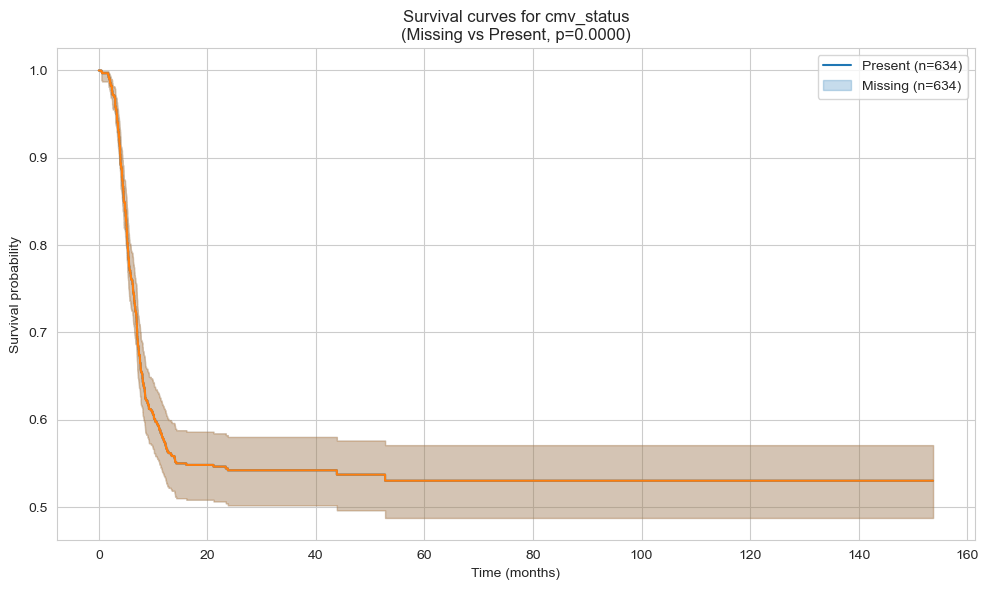

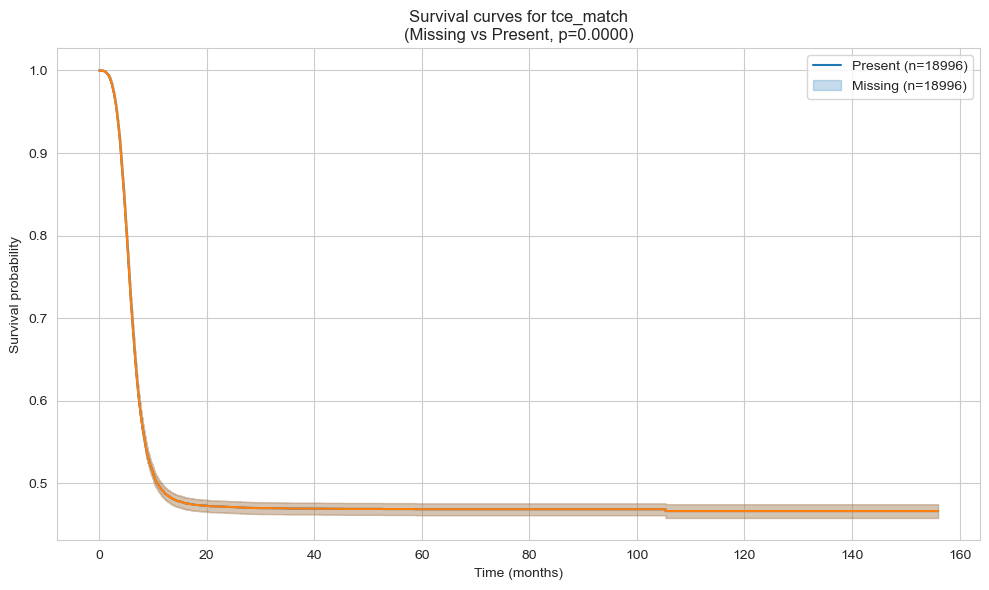

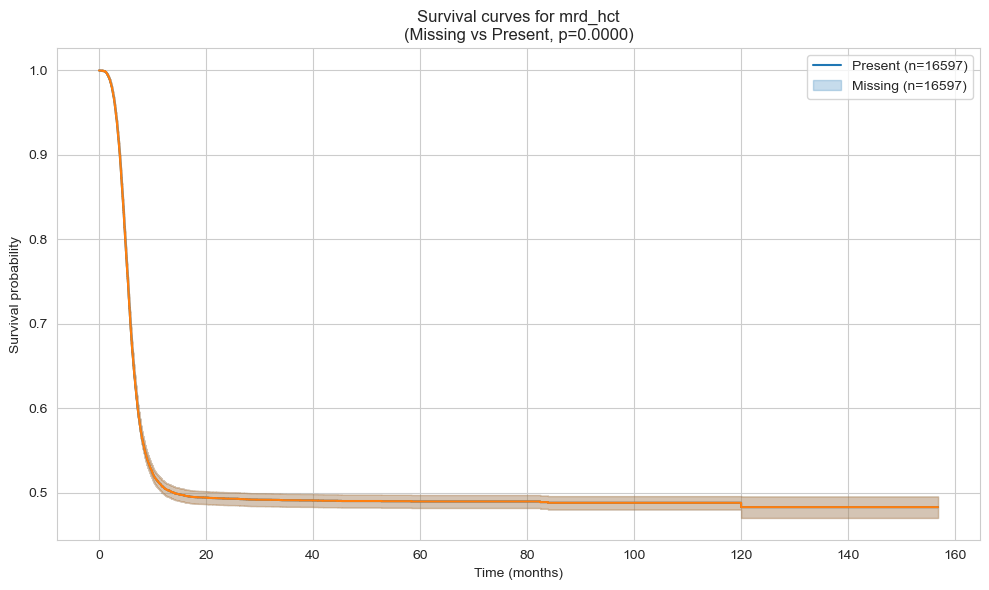

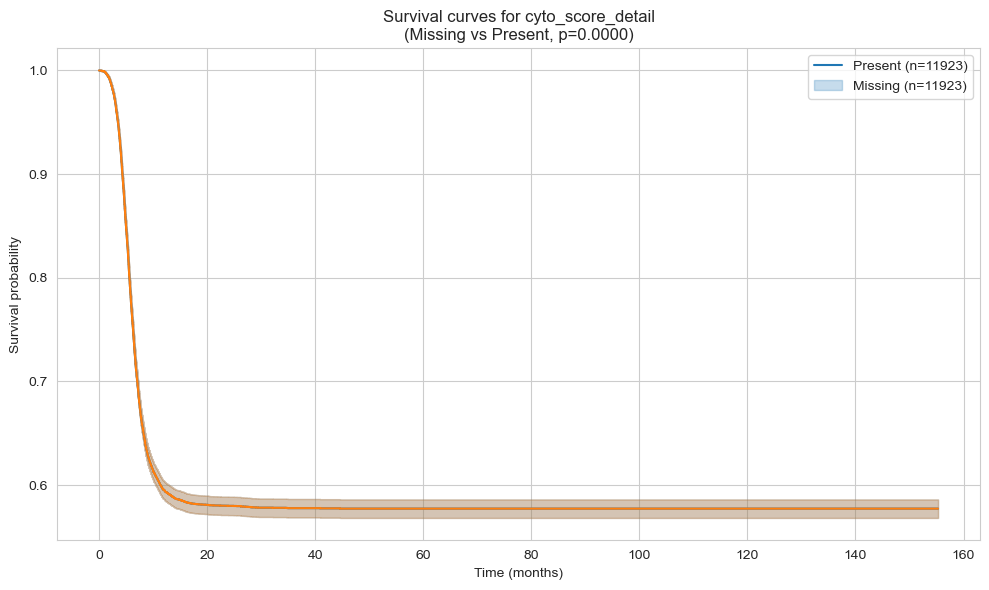

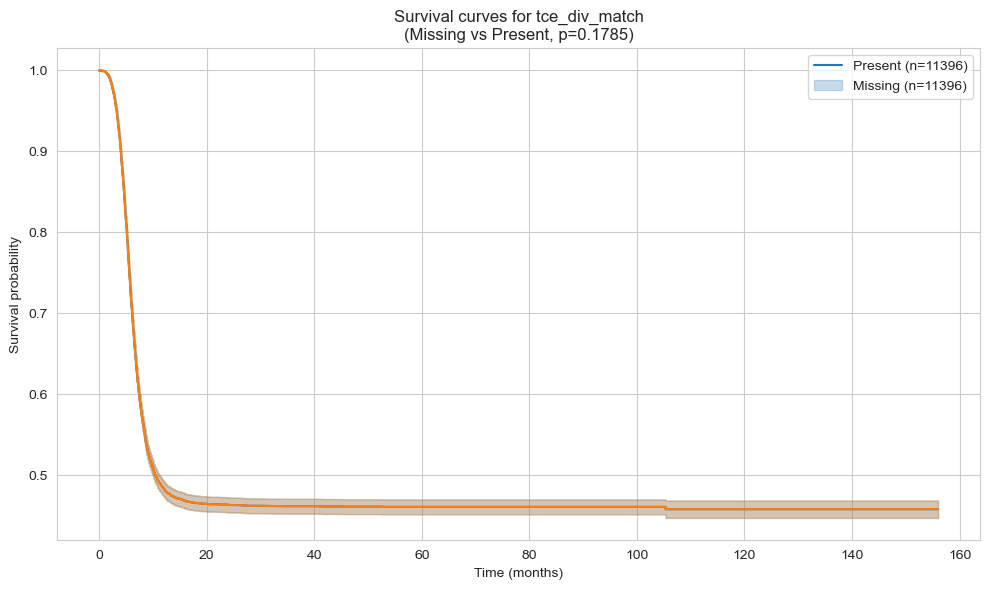

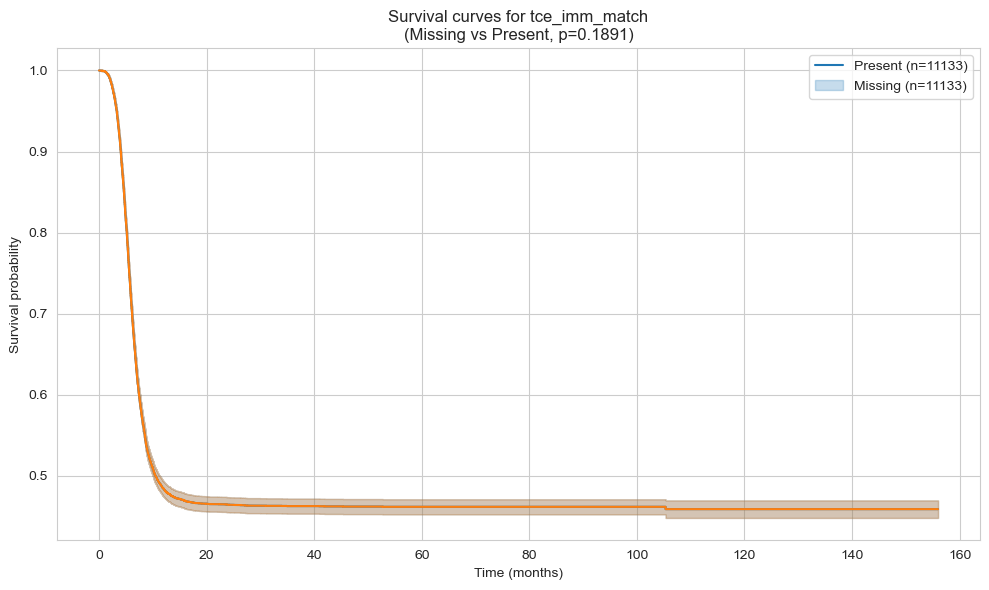

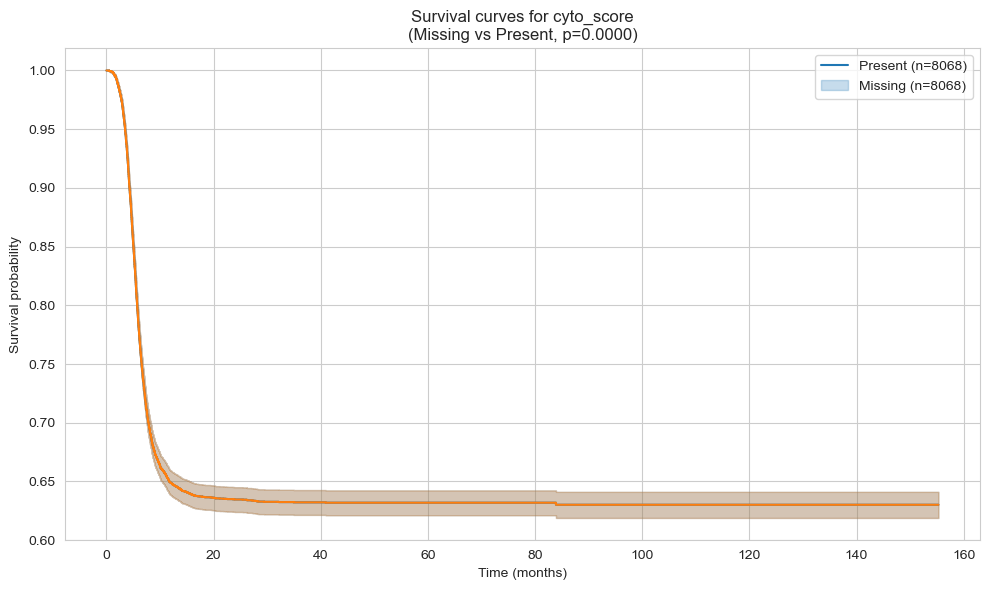

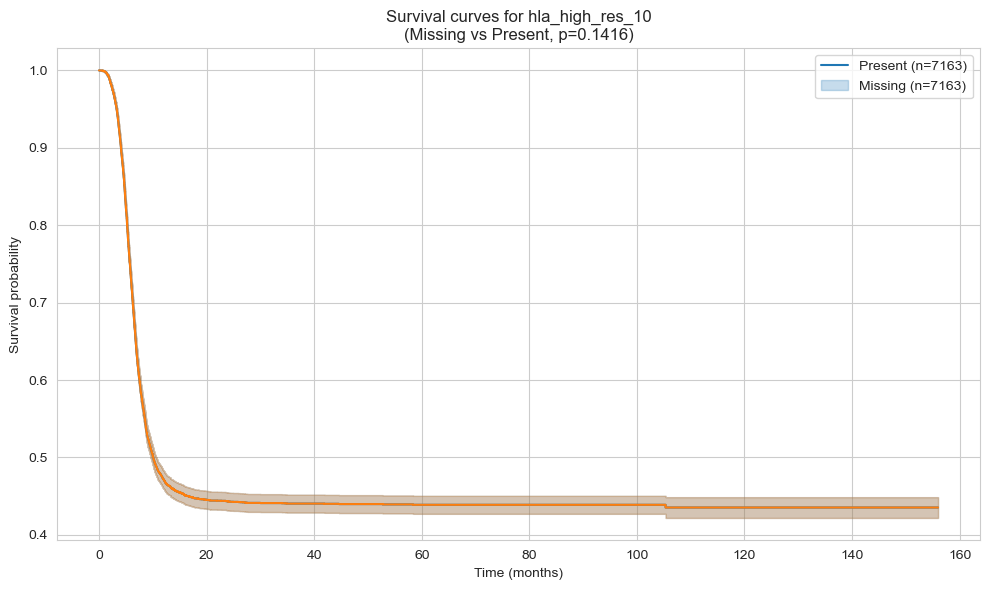

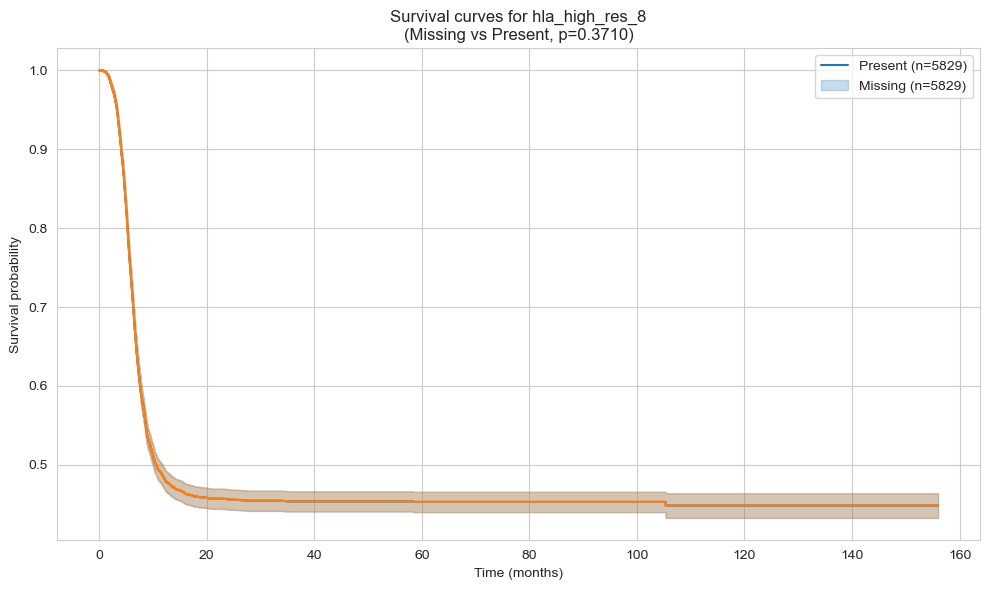

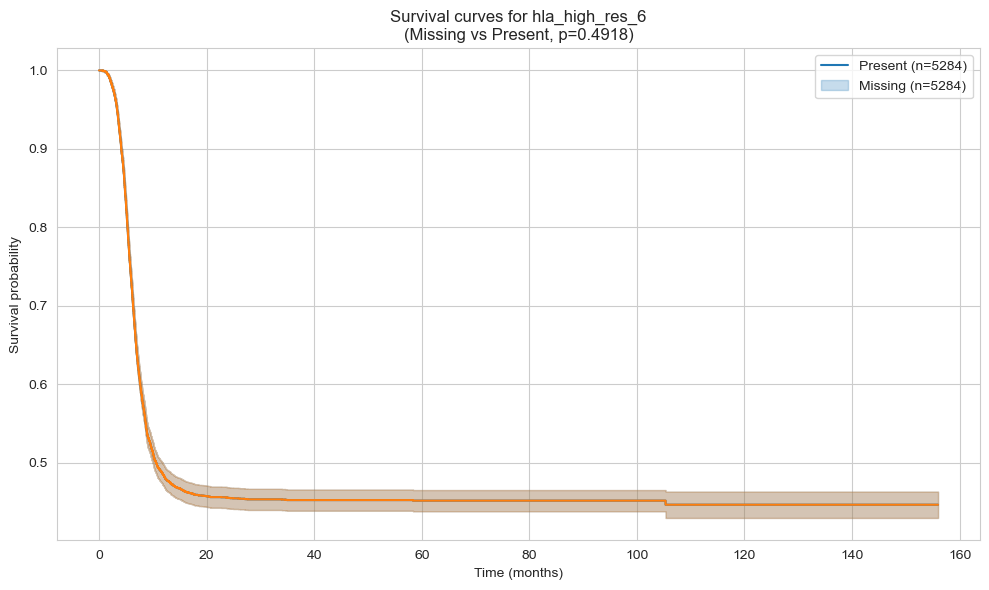

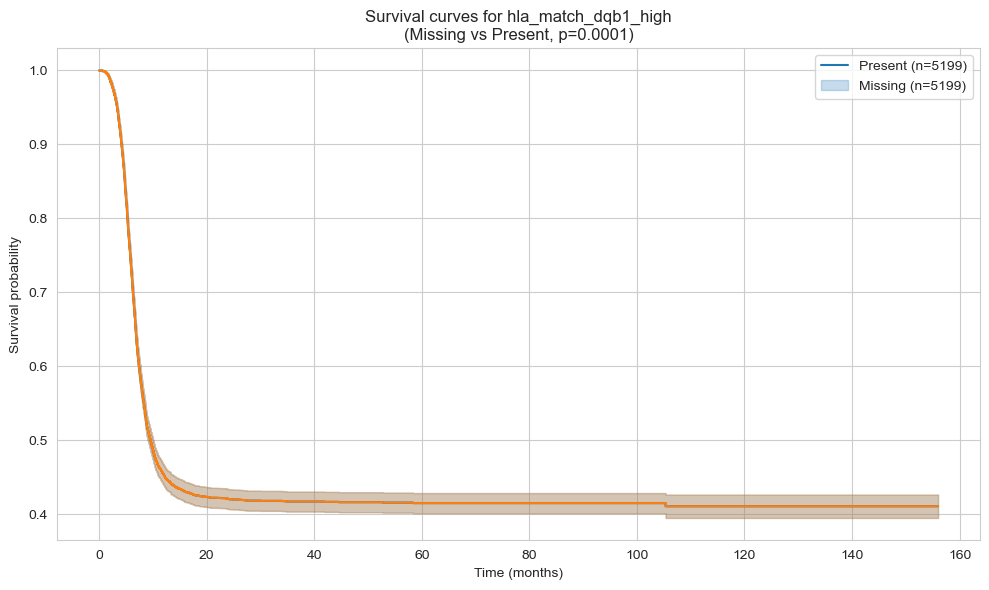

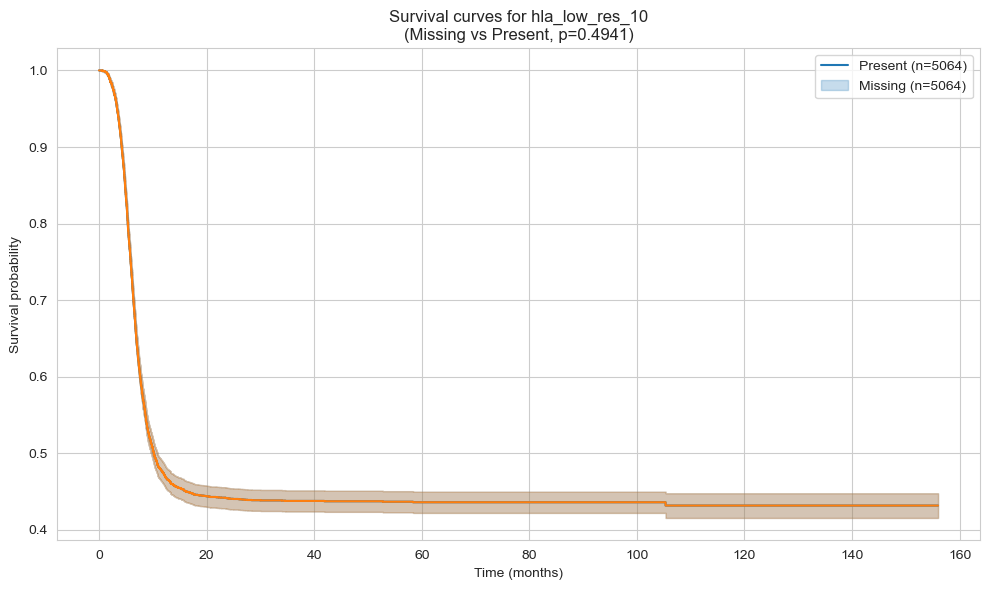

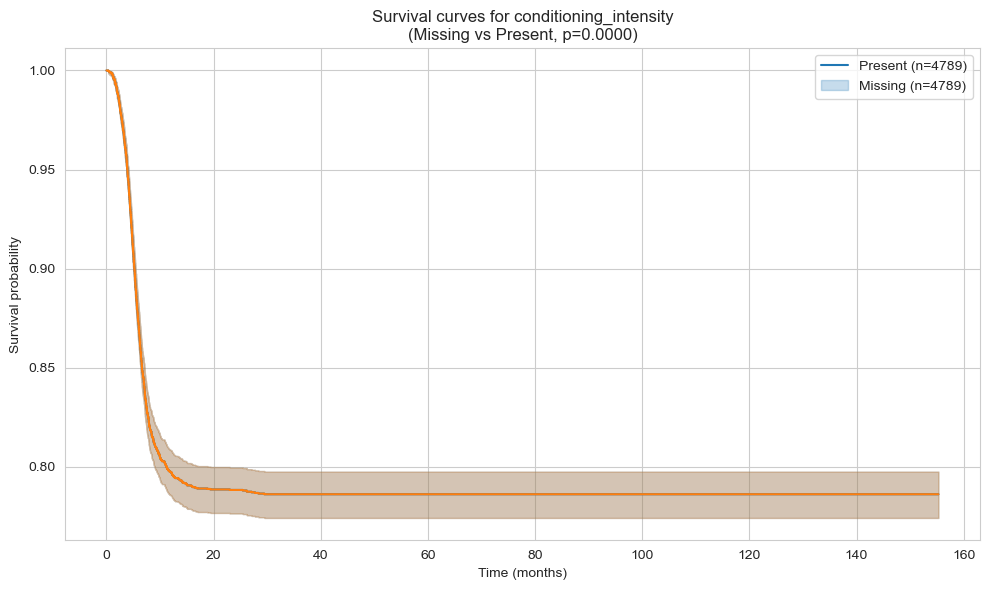

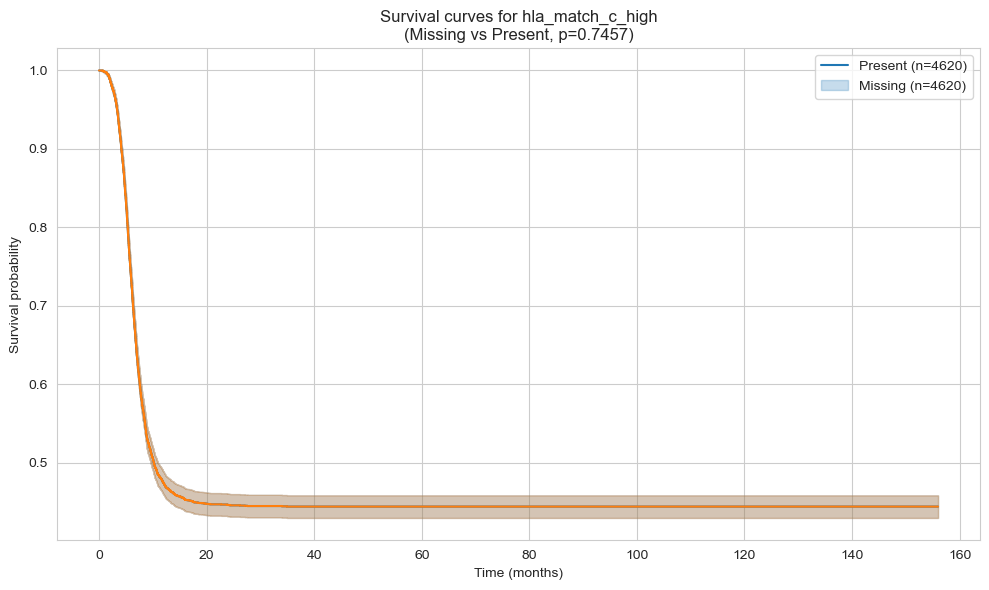

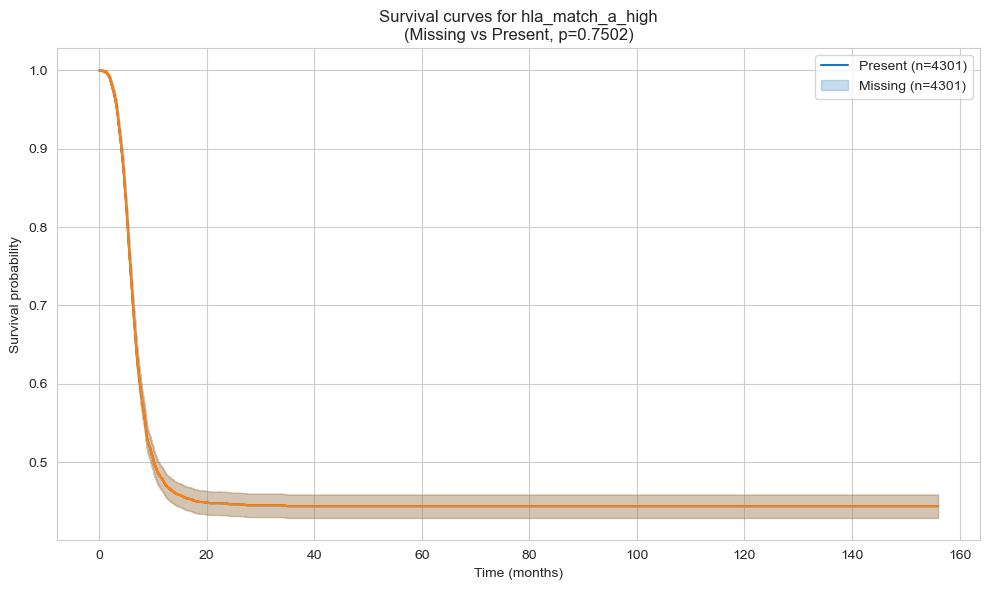

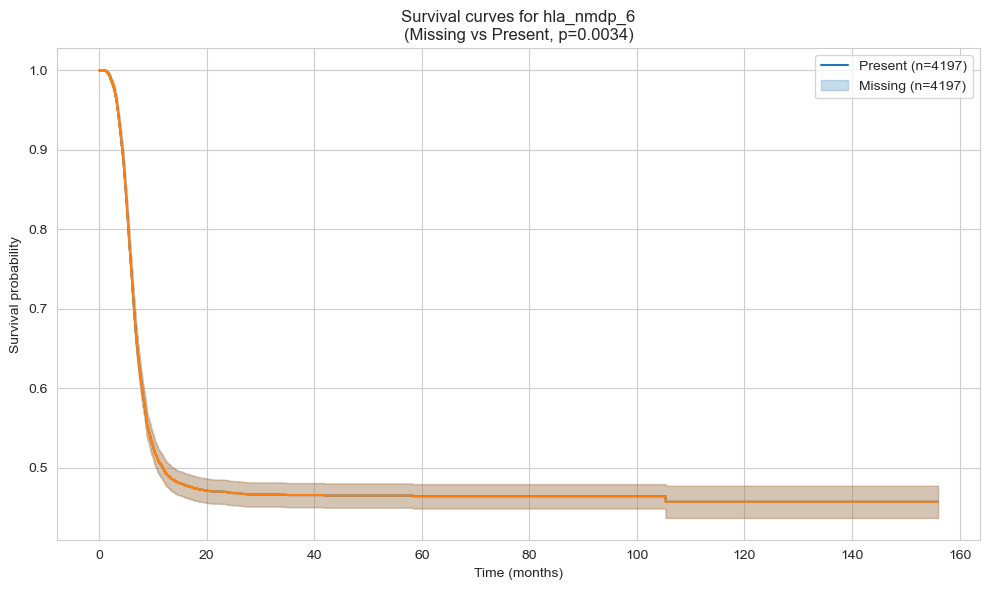

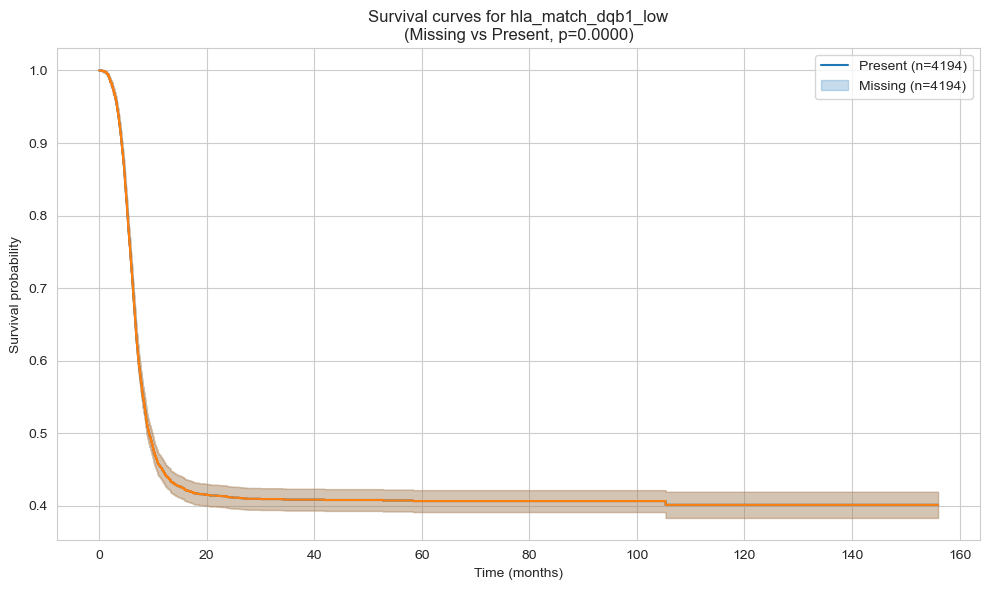

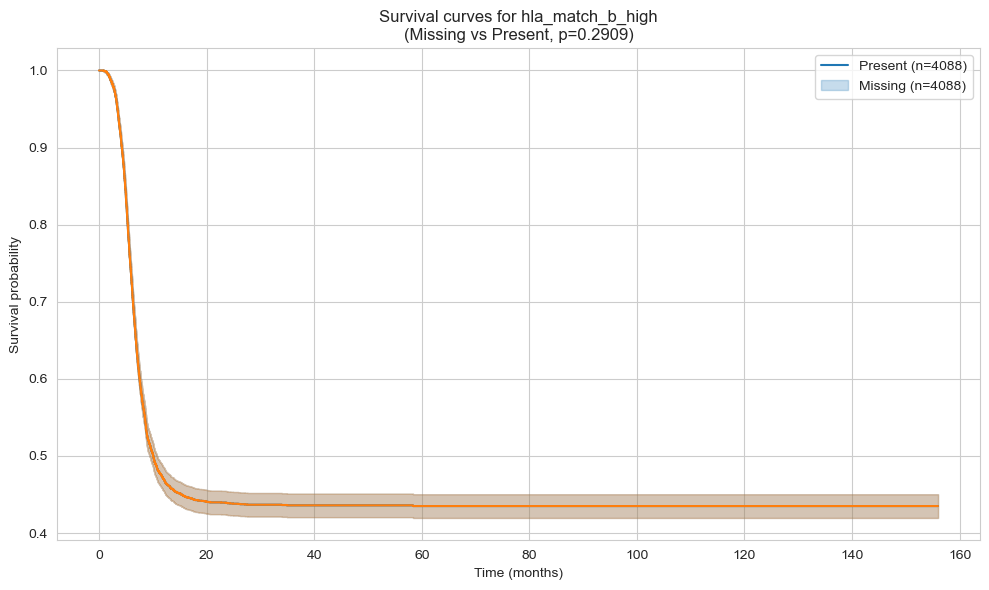

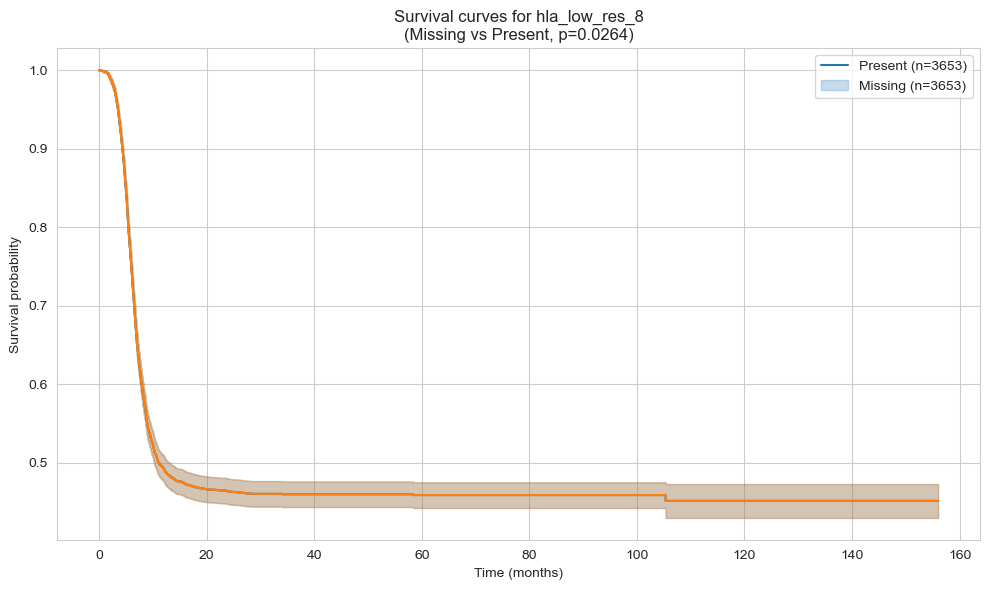

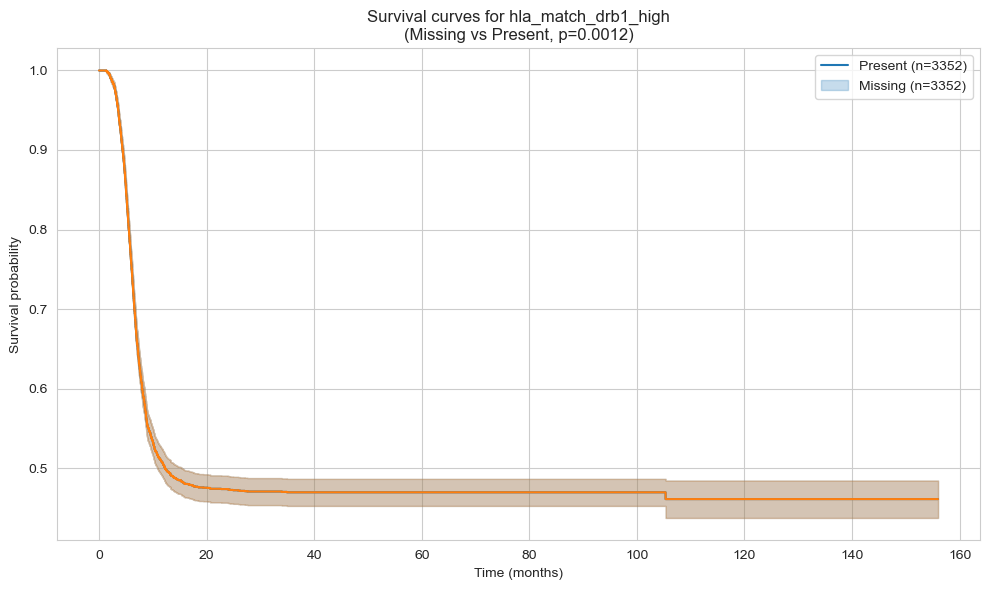

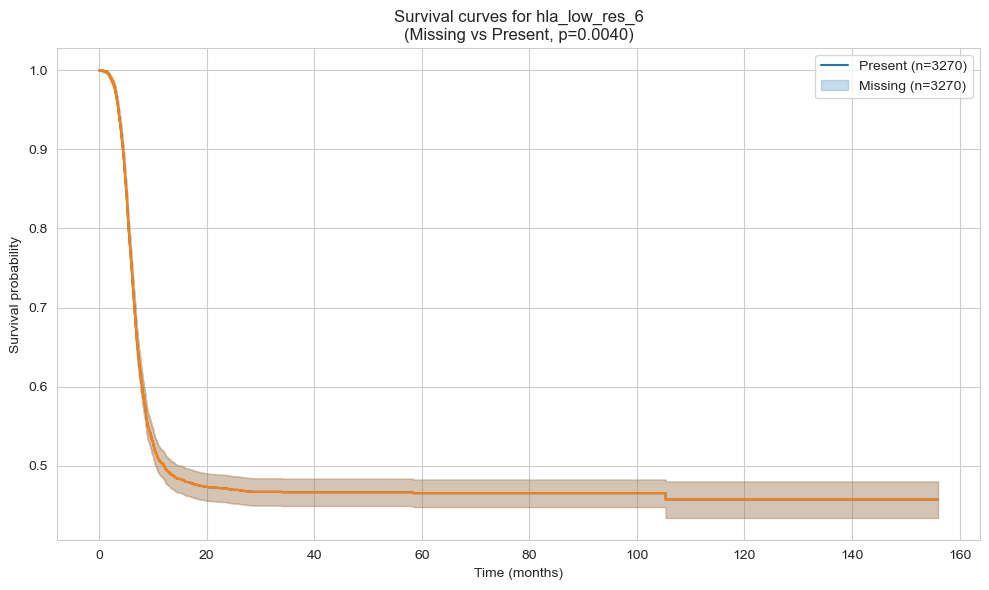

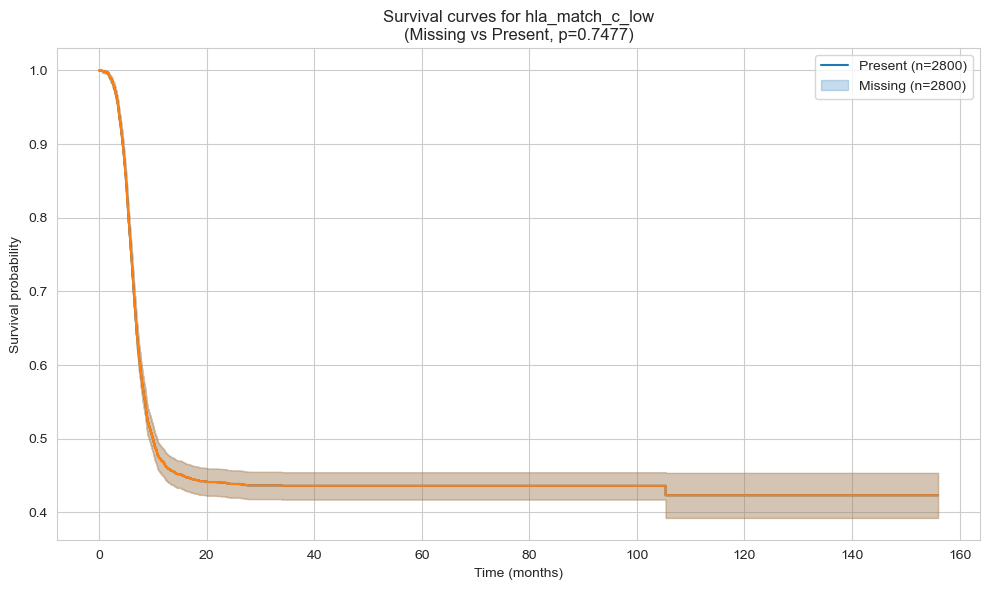

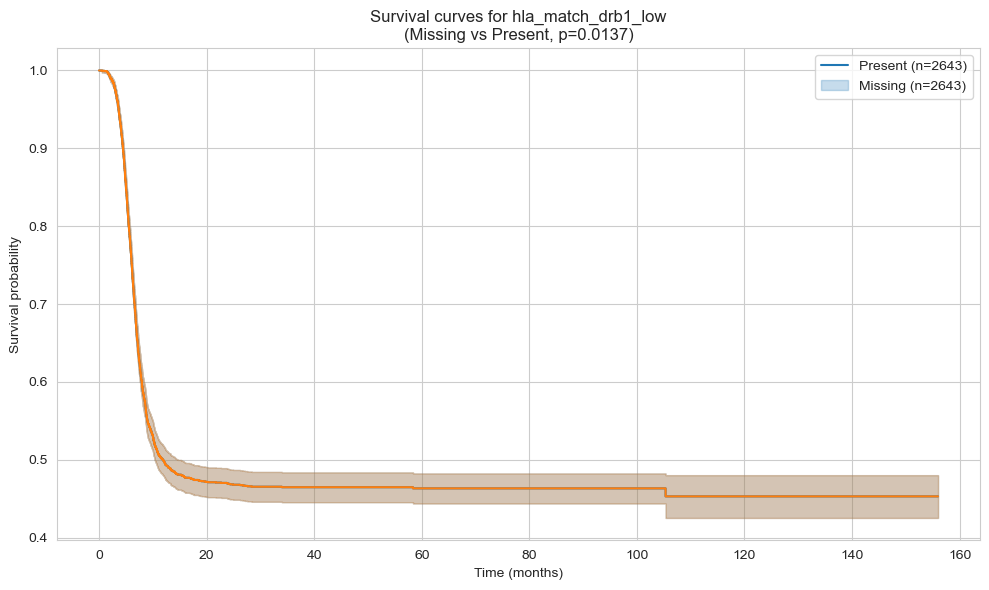

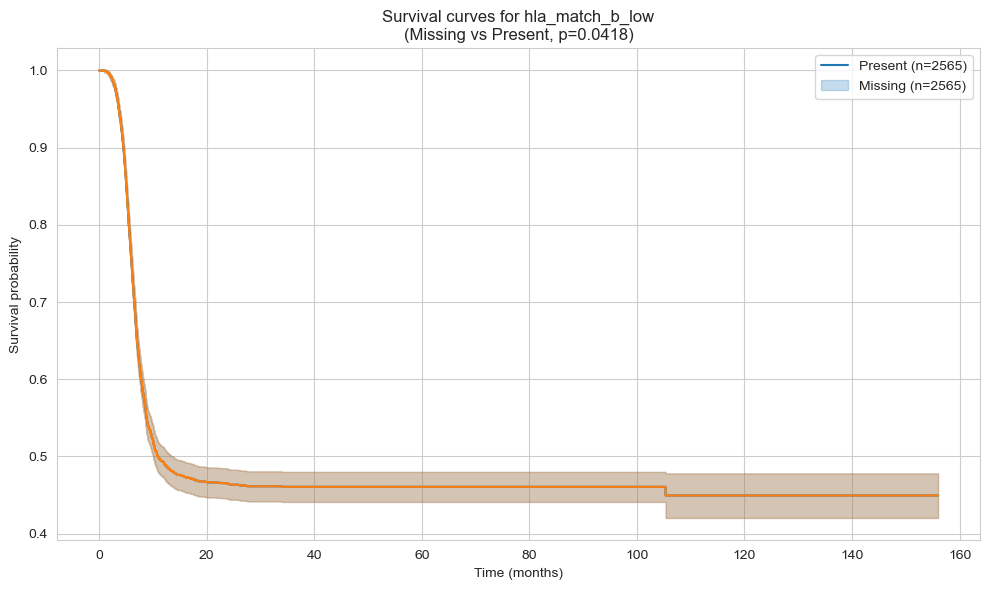

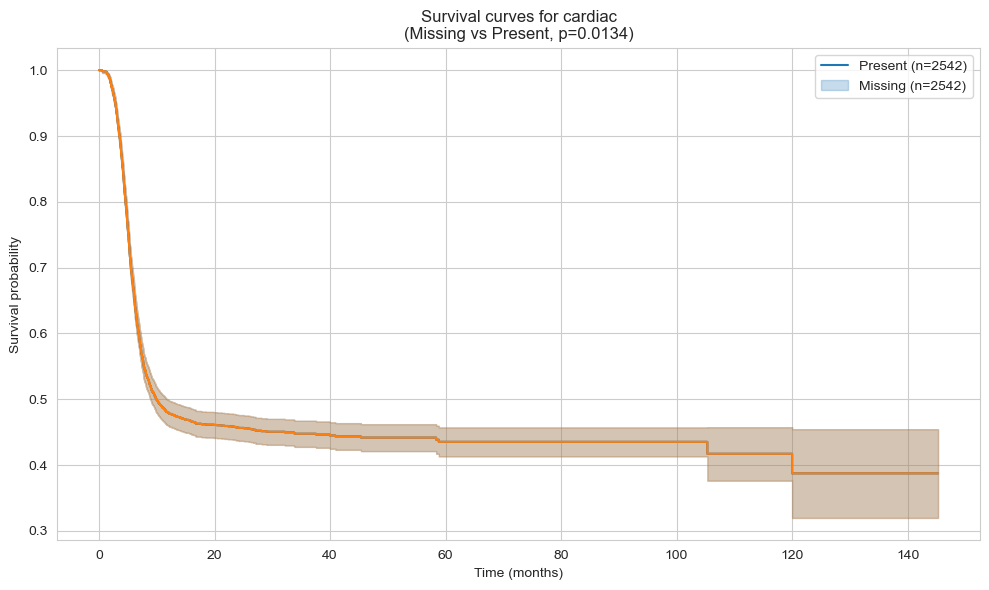

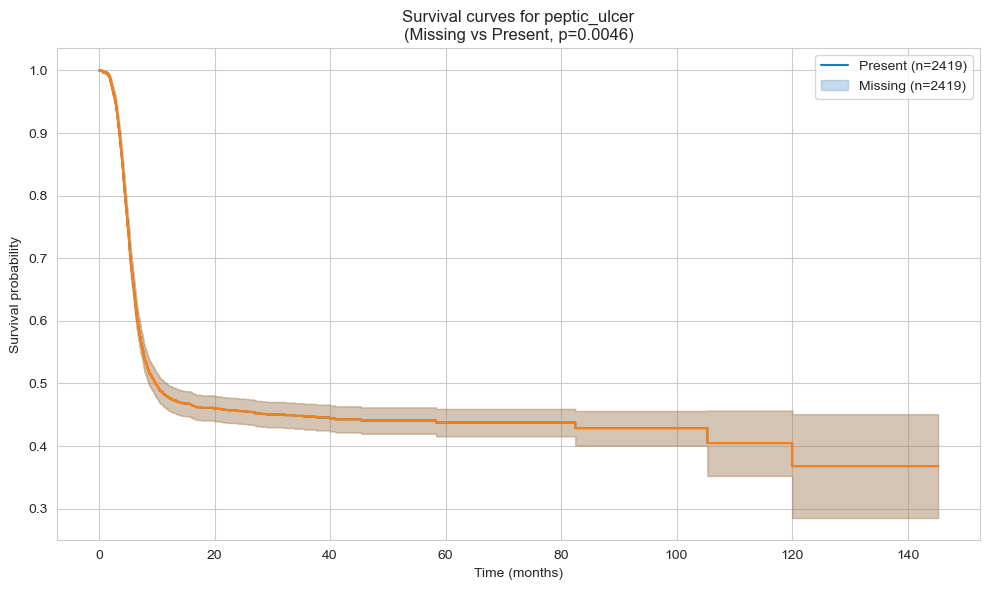

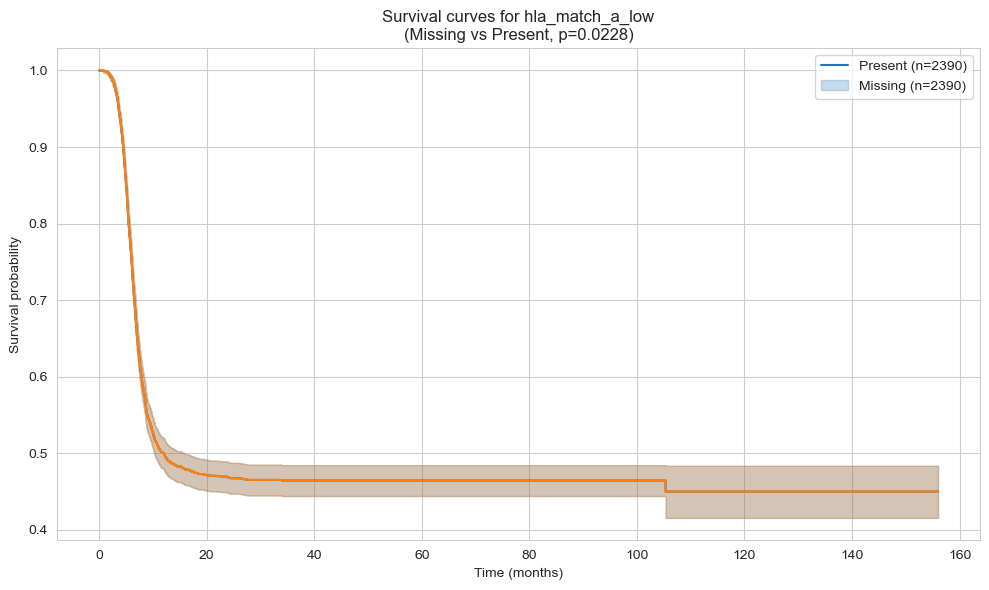

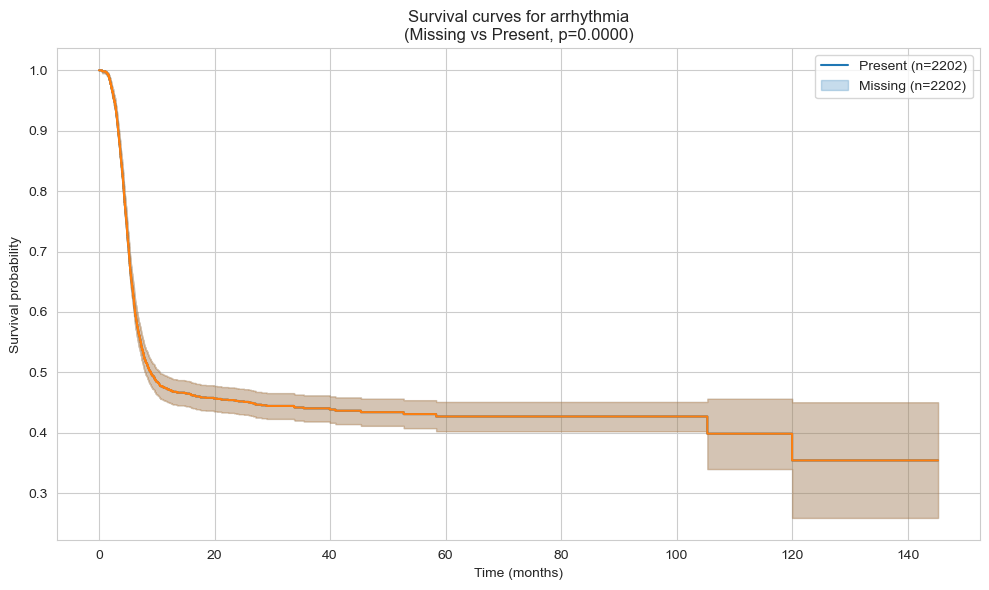

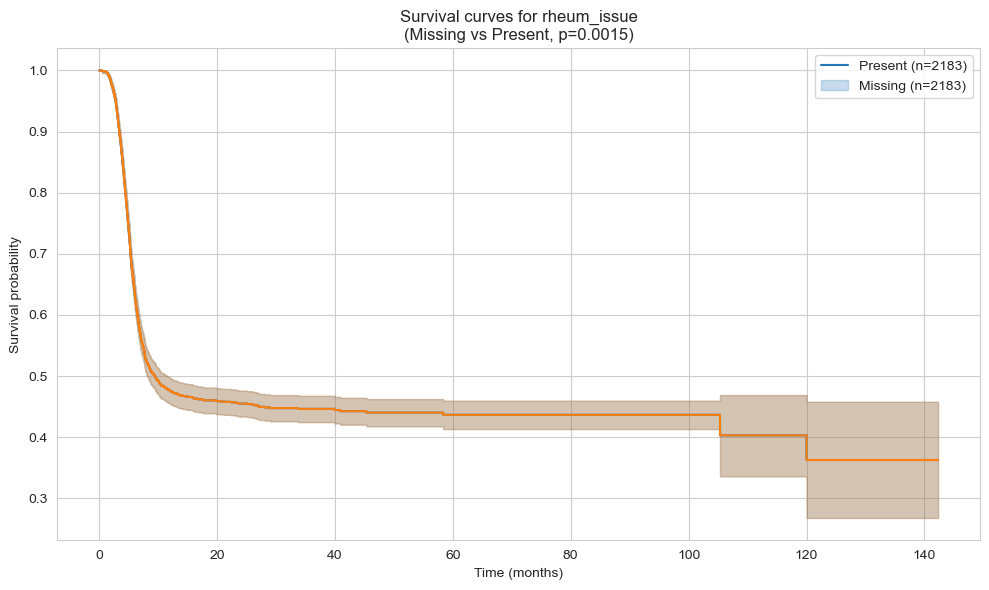

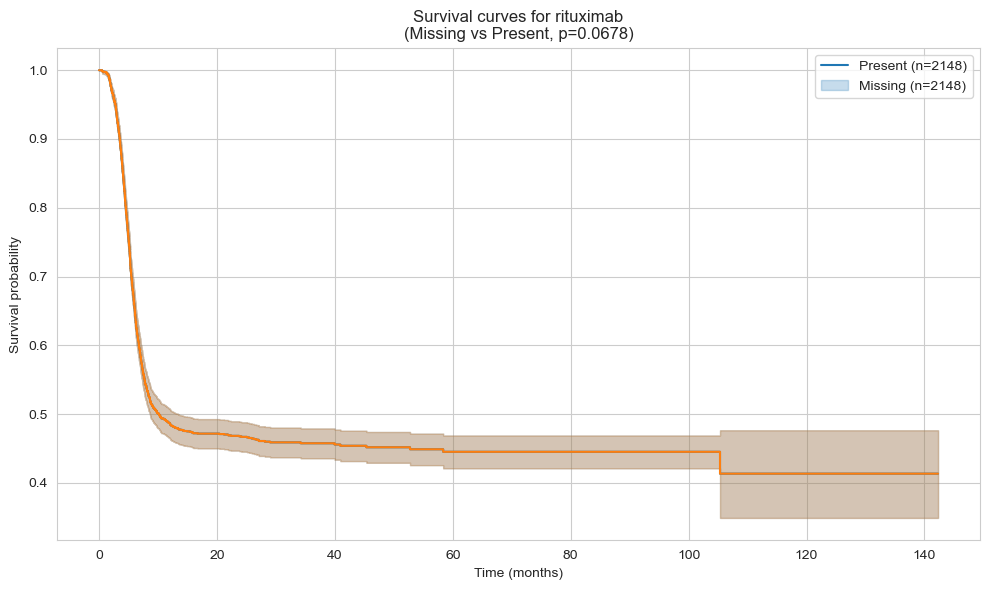

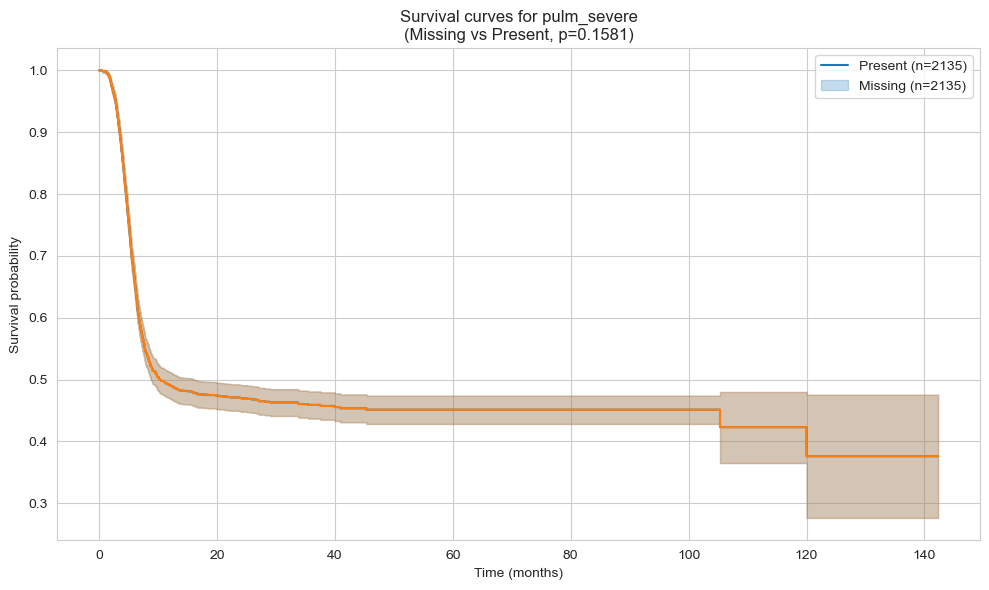

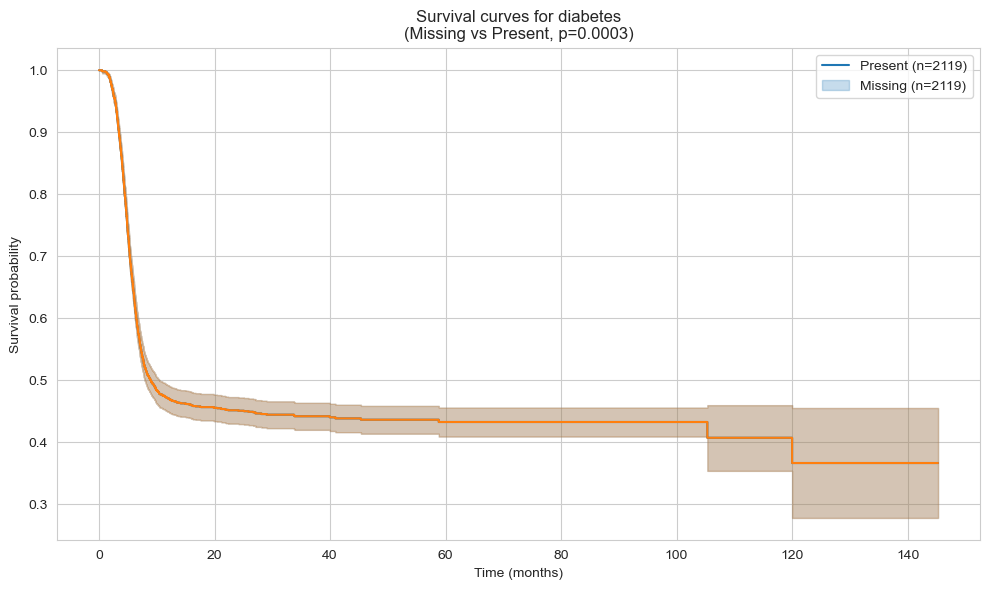

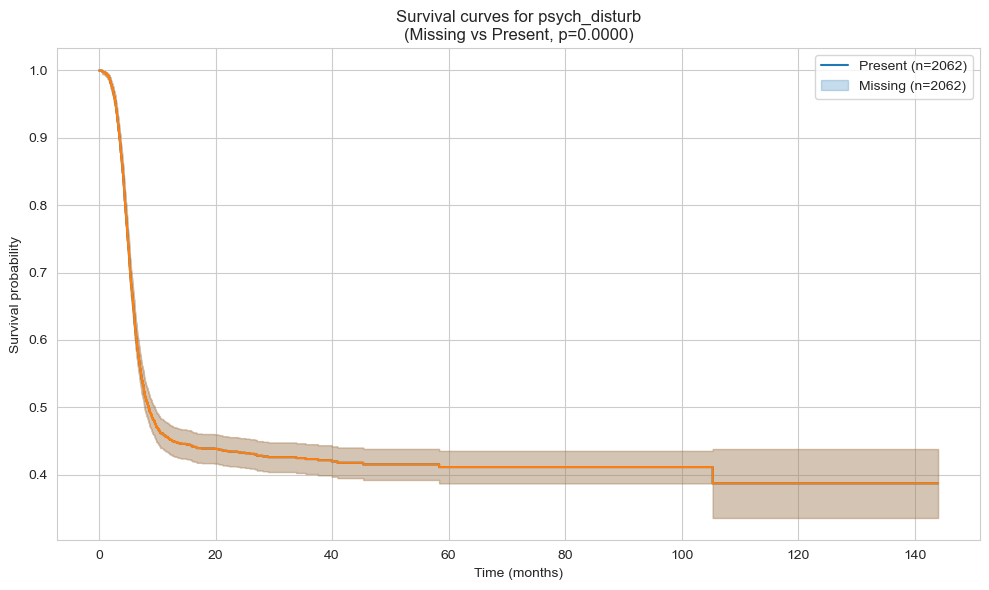

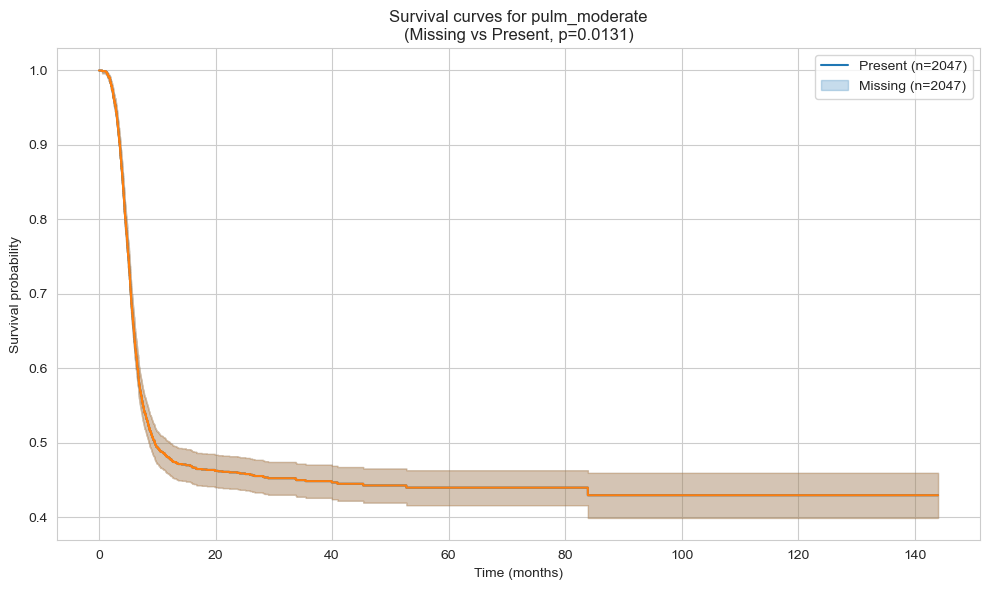

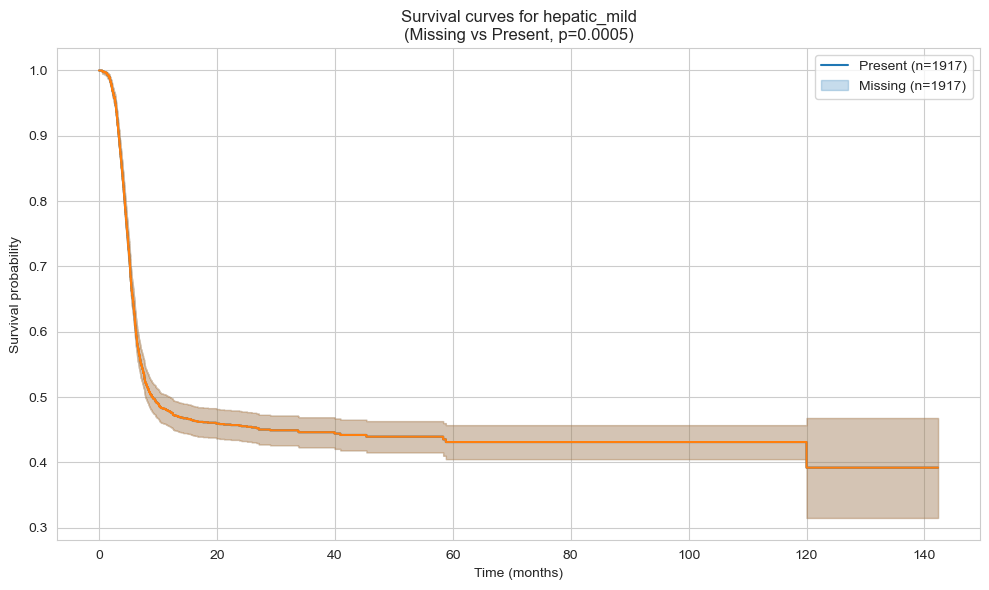

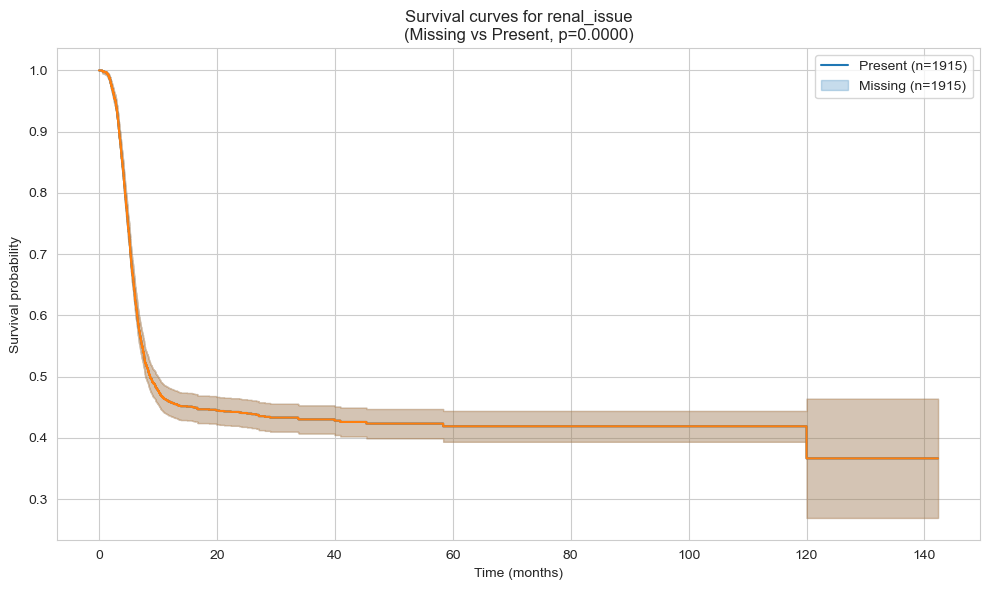

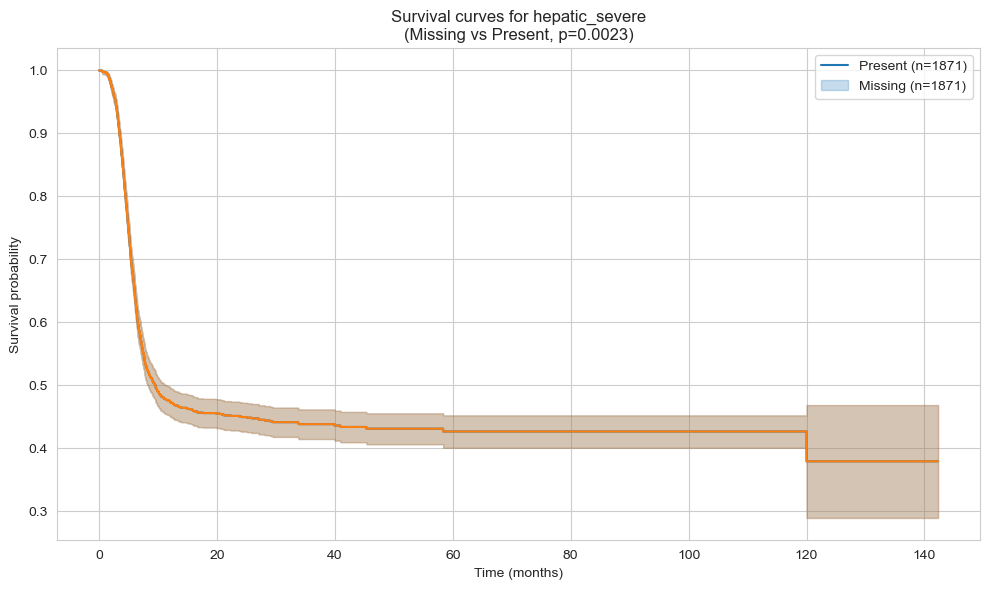

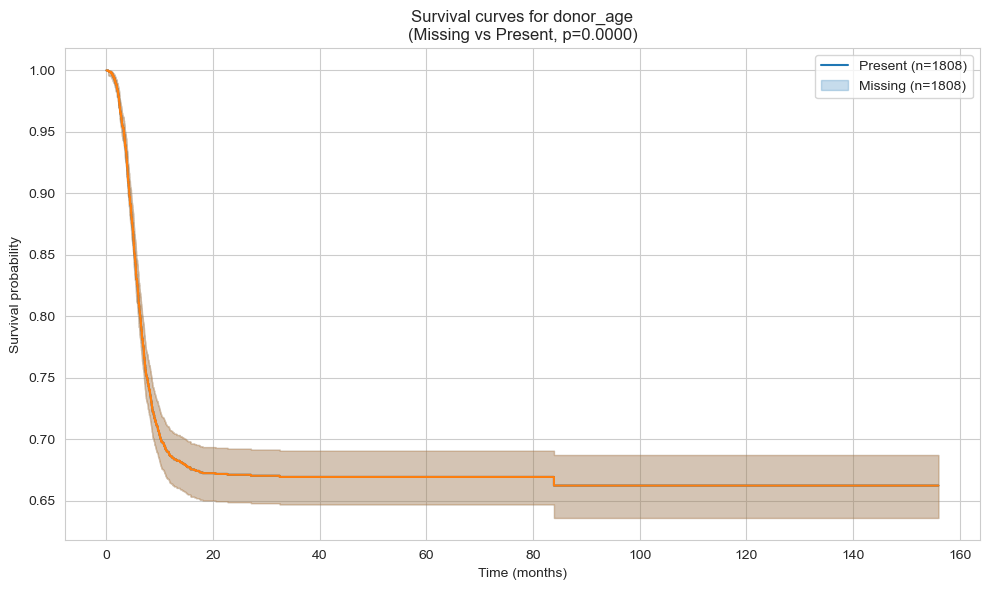

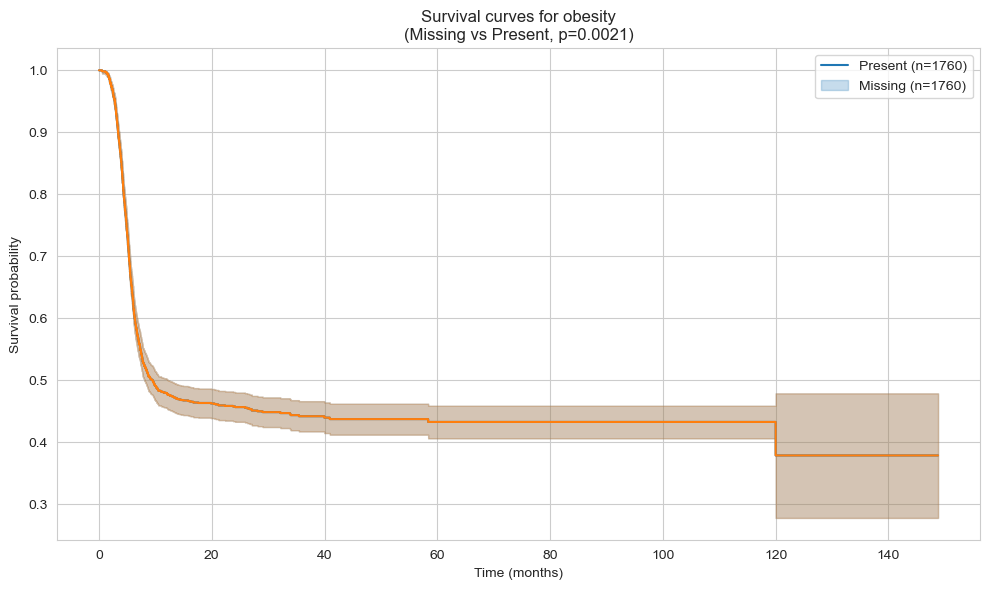

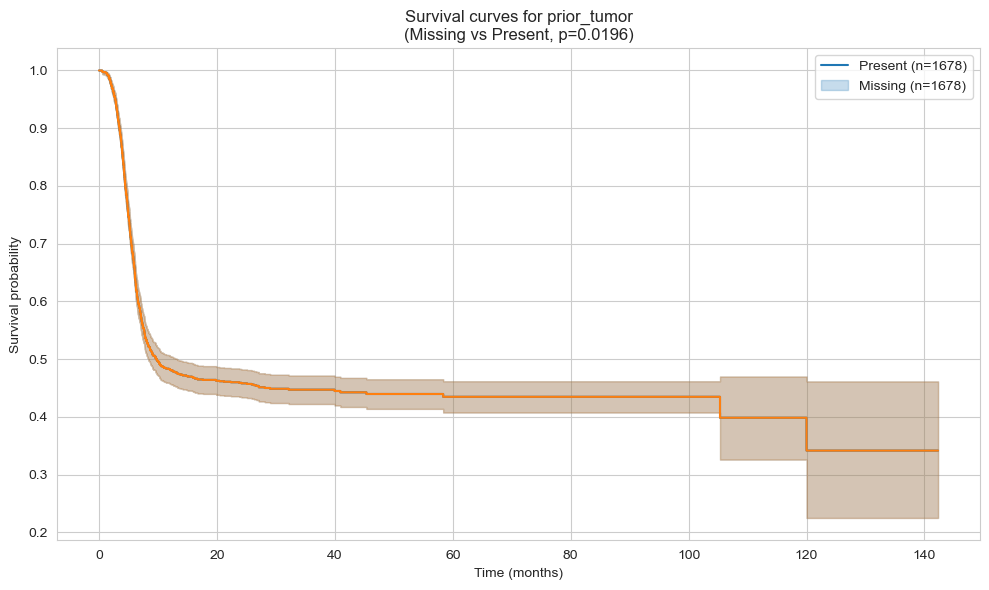

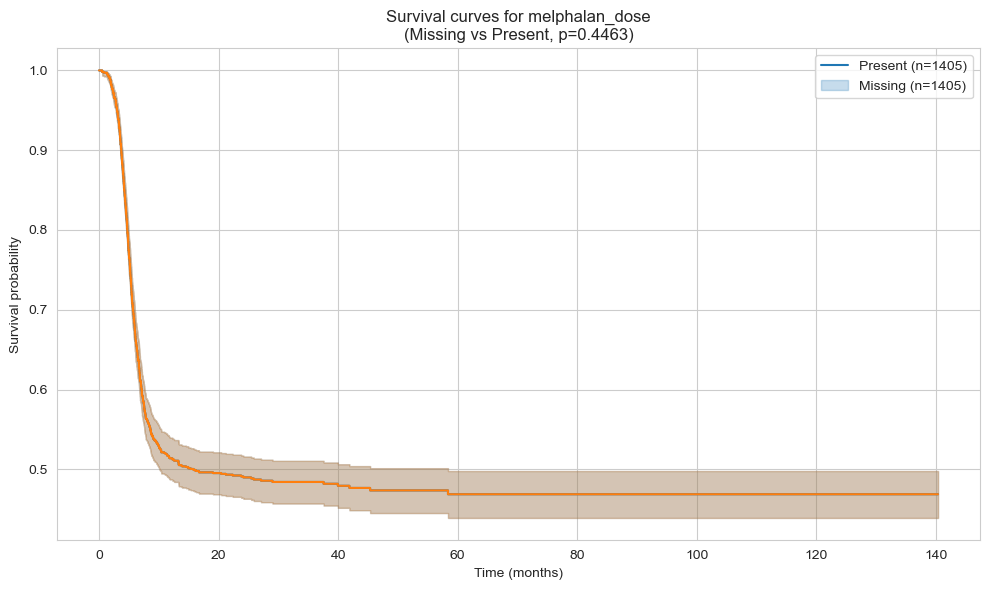

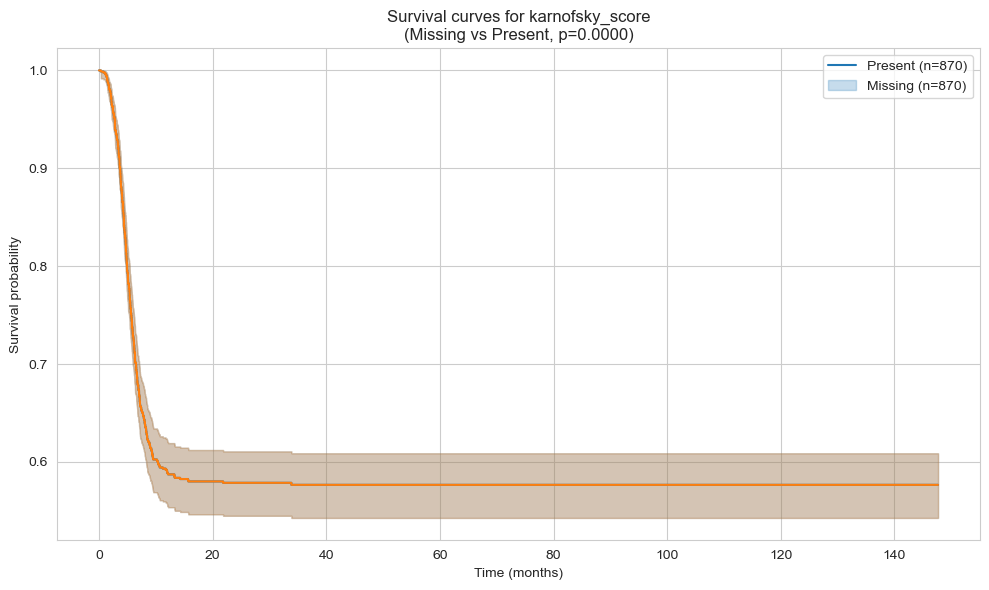

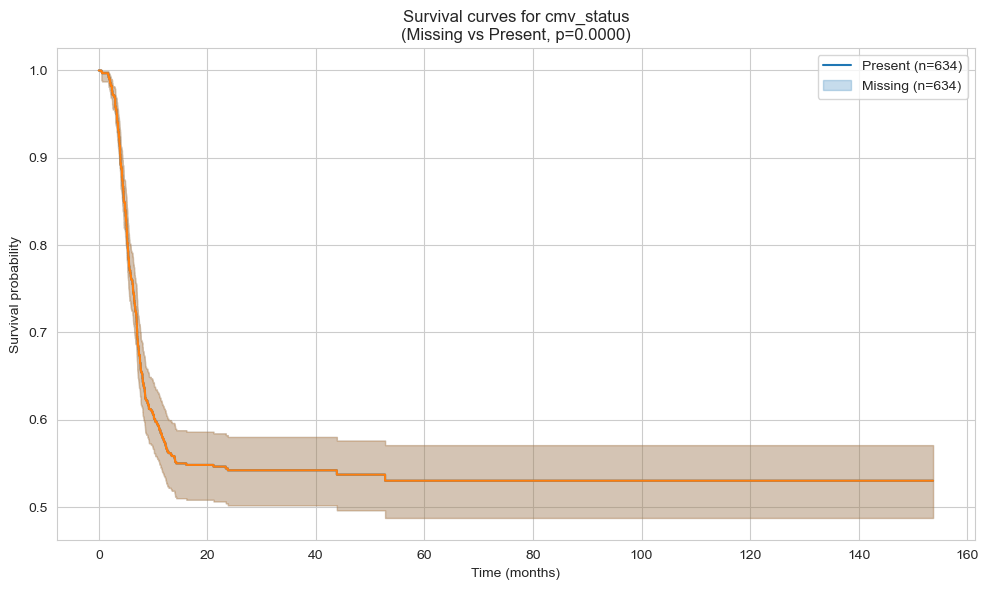

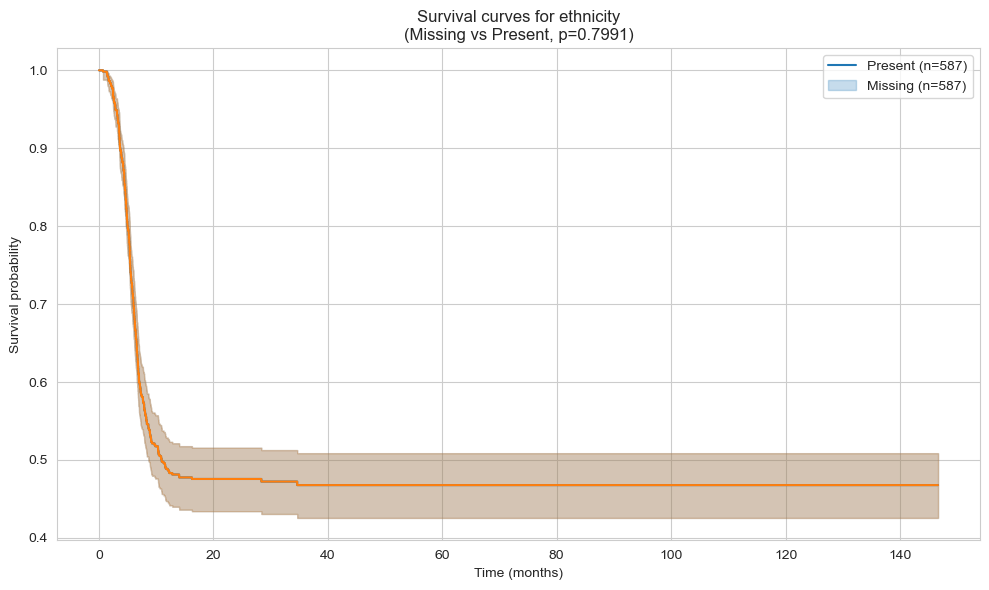

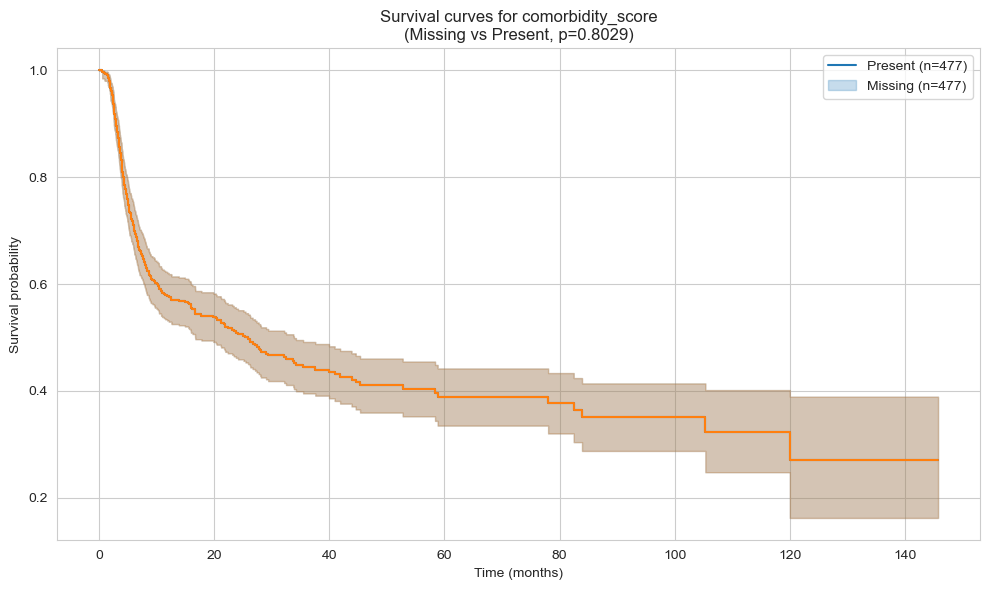

,feature,missing_count,missing_percentage,logrank_statistic,p_value
11,conditioning_intensity,4789,16.63,1924.443533,0.000000e+00
5,cyto_score,8068,28.01,1128.586286,2.022509e-247
2,cyto_score_detail,11923,41.40,1071.903515,4.222476e-235
36,donor_age,1808,6.28,275.416908,7.487903e-62
1,mrd_hct,16597,57.63,54.666987,1.427848e-13
40,karnofsky_score,870,3.02,32.781533,1.031198e-08
0,tce_match,18996,65.96,25.816281,3.755076e-07
31,psych_disturb,2062,7.16,23.665043,1.146462e-06
15,hla_match_dqb1_low,4194,14.56,18.726286,1.508881e-05
26,arrhythmia,2202,7.65,18.125562,2.068064e-05


In [13]:
# Initialize the analyzer
analyzer = MissingnessAnalyzer(df)

# Get summary of missingness
summary = analyzer.get_missingness_summary()

# Analyze a single feature
result = analyzer.analyze_feature_missingness('cmv_status')

# Analyze all features with missingness between 1% and 99%
all_results = analyzer.analyze_all_features(min_missing_pct=1, max_missing_pct=99)

# Modify the analyze_all_features method to show plots
analyzer.analyze_all_features(min_missing_pct=1, max_missing_pct=99, plot=True)

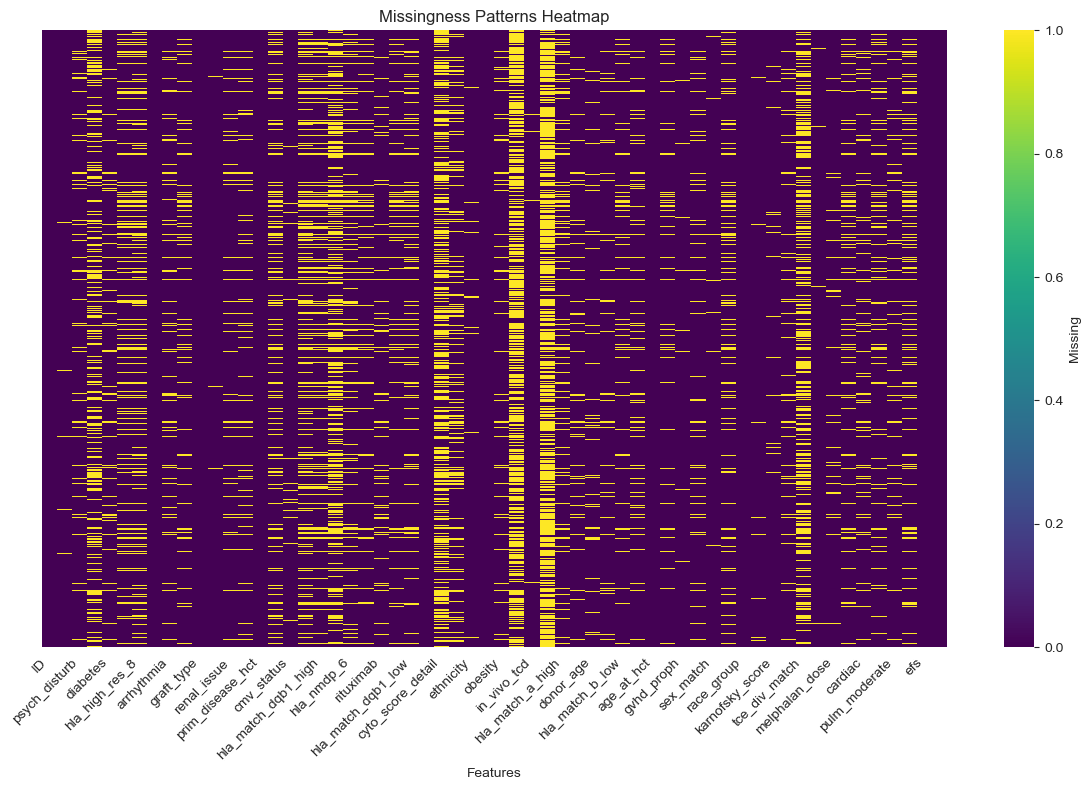

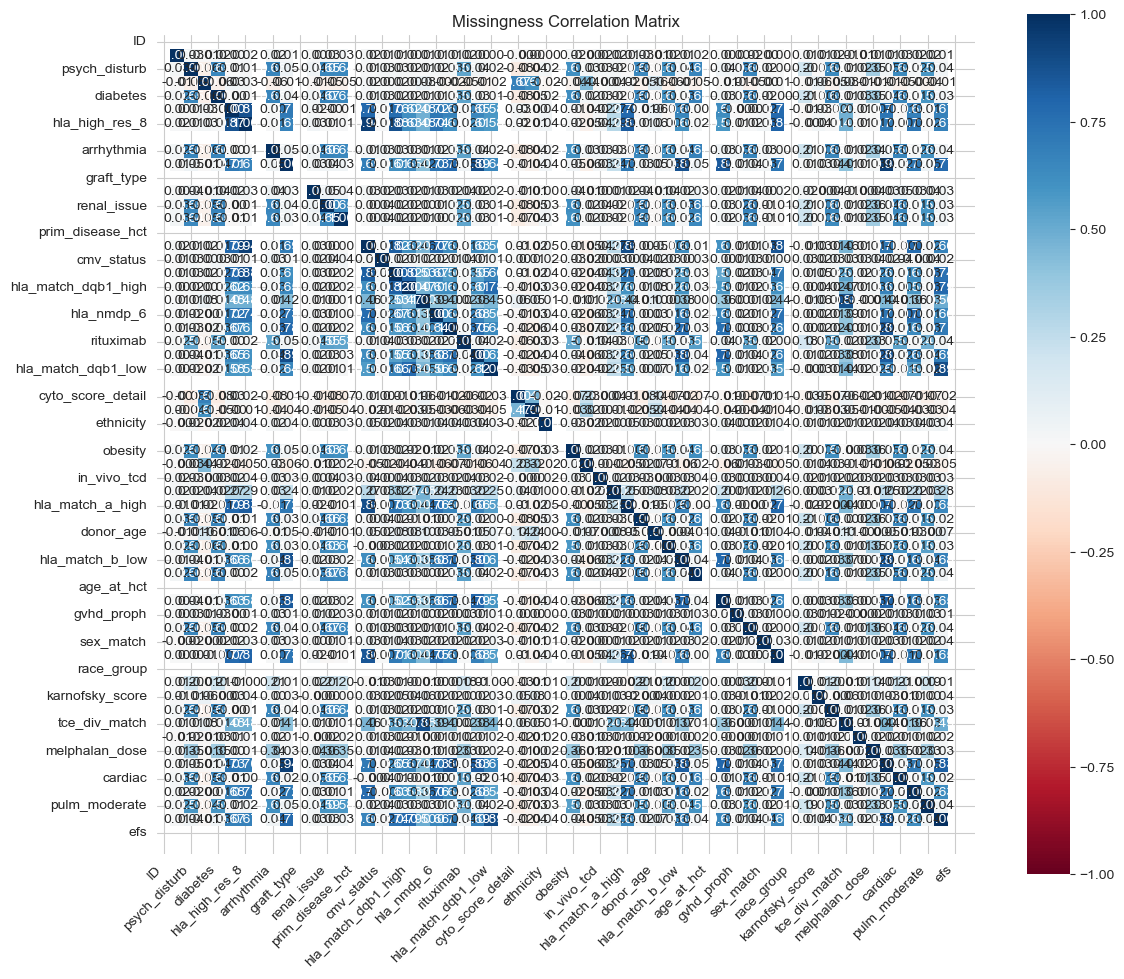

In [14]:
# Plot missingness patterns
analyzer.plot_missingness_heatmap()

# Plot correlations between missing values
analyzer.plot_missingness_correlation()

In [15]:
# Get missingness summary
missing_info = df.isnull().sum().sort_values(ascending=False)
missing_percentages = (df.isnull().sum() / len(df) * 100).round(2).sort_values(ascending=False)

print("Missing counts and percentages:")
for col, count in missing_info.items():
    pct = missing_percentages[col]
    print(f"{col}: {count} values ({pct}%)")

Missing counts and percentages:
tce_match: 18996 values (65.96%)
mrd_hct: 16597 values (57.63%)
cyto_score_detail: 11923 values (41.4%)
tce_div_match: 11396 values (39.57%)
tce_imm_match: 11133 values (38.66%)
cyto_score: 8068 values (28.01%)
hla_high_res_10: 7163 values (24.87%)
hla_high_res_8: 5829 values (20.24%)
hla_high_res_6: 5284 values (18.35%)
hla_match_dqb1_high: 5199 values (18.05%)
hla_low_res_10: 5064 values (17.58%)
conditioning_intensity: 4789 values (16.63%)
hla_match_c_high: 4620 values (16.04%)
hla_match_a_high: 4301 values (14.93%)
hla_nmdp_6: 4197 values (14.57%)
hla_match_dqb1_low: 4194 values (14.56%)
hla_match_b_high: 4088 values (14.19%)
hla_low_res_8: 3653 values (12.68%)
hla_match_drb1_high: 3352 values (11.64%)
hla_low_res_6: 3270 values (11.35%)
hla_match_c_low: 2800 values (9.72%)
hla_match_drb1_low: 2643 values (9.18%)
hla_match_b_low: 2565 values (8.91%)
cardiac: 2542 values (8.83%)
peptic_ulcer: 2419 values (8.4%)
hla_match_a_low: 2390 values (8.3%)
arrh